#### Auszuführen mit Environment "tf"

#### Importe & Definitionen

In [1]:
import tensorflow as tf
from keras import backend as K
import tifffile
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import json
import csv
import random
from time import time
import shutil


# Definition des Data-Generators
class CustomDataGenerator(tf.keras.utils.Sequence):
 
    def __init__(self, batch_size, img_directory, msk_directory, shuffle= False, augment= False):
        self.batch_size = batch_size
        self.img_directory = img_directory
        self.msk_directory = msk_directory
        self.list_img_IDs = os.listdir(self.img_directory)
        self.list_msk_IDs = os.listdir(self.msk_directory)
        self.shuffle = shuffle
        self.augment = augment

    def augment_data(self, x, y):     
        x_flip = x
        y_flip = y

        # zufällige horizontale & vertikale Flips
        horiz = random.randint(0, 9)
        if horiz <= 4:
            x_flip = np.fliplr(x)
            y_flip = np.fliplr(y)

        vert = random.randint(0, 9)
        if vert <= 4:
            x_flip = np.flipud(x_flip)
            y_flip = np.flipud(y_flip)
        
        return x_flip, y_flip

    def __len__(self):

        return len(os.listdir(self.img_directory)) // self.batch_size
    
    def __getitem__(self, index):
        batch_img_IDs = self.list_img_IDs[index*self.batch_size : (index+1)*self.batch_size]
        batch_msk_IDs = self.list_msk_IDs[index*self.batch_size : (index+1)*self.batch_size]

        images = []
        masks = []
        for img_id, msk_id in zip(batch_img_IDs, batch_msk_IDs):
            # einlesen Bild
            img_path = os.path.join(self.img_directory, img_id)
            with open(img_path, 'rb') as f:
                image = tifffile.imread(f)

            # Transformation in "channels_last"-Format
            image = np.moveaxis(image, 0, -1)
            
            # einlesen Maske
            msk_path = os.path.join(self.msk_directory, msk_id)
            with open(msk_path, 'rb') as f:
                mask = tifffile.imread(f)

            # Erstellen einer zusätzlichen Achse um Tensor-Dimension zu erreichen
            mask = mask[:, :, np.newaxis]

            # Data Augmentation
            if self.augment:
                image, mask = self.augment_data(image, mask)

            # Skalierung der Werte
            images.append((image / 127.5) - 1)
            masks.append(mask/255)
        
        return (np.array(images), np.array(masks))
    
    def on_epoch_end(self):
        if self.shuffle:
            a = self.list_img_IDs
            b = self.list_msk_IDs

            c = list(zip(a, b))

            random.shuffle(c)

            self.list_img_IDs, self.list_msk_IDs = zip(*c)


# Definition des Dice-Koeffizienten
def Dice_coefficient(y_true, y_pred, smooth=10e-6):        
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice


# Ableitung einer zu minimierenden Loss-Funktion aus Dice-Koeffzient
def Dice_loss(y_true, y_pred):
    return 1 - Dice_coefficient(y_true, y_pred)


# Rückgängig machen der Normalisierung zur korrekten Anzeige der Bilder
def reverse_scaling(image):
    return (((image + 1) / 2 )* 255).astype(np.uint8)


def load_model(model_type):
    # Speicherpfade der verschiedenen Architekturen
    model_dict = {
        'BASIC': './model_config_files/conf.json',
        'CONV': './model_config_files/conf_RGB_addConv3.json',
        'SPLIT': './model_config_files/conf_splitRGB.json'
        }

    # Auswahl der Architektur entsprechend der verwendeten Variante
    path = model_dict[model_type]

    # Laden der JSON
    with open(path, 'r', encoding='utf-8') as f:
        new_conf = json.load(f)

    # Laden des Modells aus JSON
    unet = tf.keras.Model().from_config(new_conf)

    # Wo die shape der Gewichte des Layers es zulässt, werden immer die selben zufällig initialisierten Gewichte verwendet
    random_path = './saved_weights/unet_resnet50v2_random.npy'

    # entsprechend der Variante müssen Gewichte unterschiedlich gesetzt werden
    if model_type == 'BASIC':
        loaded_weights = np.load(random_path, allow_pickle= True)
        unet.set_weights(loaded_weights)


    elif model_type == 'CONV':
        # zufällige Gewichte des neu erstellten U-Nets
        unet_weights = unet.get_weights()

        # gespeicherte zufällige Gewichte für den einheitlichen Decoder-Teil des U-Nets
        loaded_weights = np.load(random_path, allow_pickle= True)

        # Leere Liste für neue Gewichte
        updated_weights = []

        # kernel und bias Gewichte des zusätzlichen Convolution-layer
        for i in range(2):
            updated_weights.append(unet_weights[i])

        # einfügen aller weiteren Gewichte
        for unet_w, loaded_w in zip(unet_weights[2:], loaded_weights):
            # für den 2. Convolution-layer passt die shape nicht, bleibt daher unberührt
            if unet_w.shape != loaded_w.shape:
                updated_weights.append(unet_w)

            # alle anderen werden durch die geladenen ersetzt
            else:
                updated_weights.append(loaded_w)

        # Einsetzen der aktualisierten Gewichte
        unet.set_weights(updated_weights)

    elif model_type == 'SPLIT':
        # zufällige Gewichte des neu erstellten U-Nets
        unet_weights = unet.get_weights()

        # gespeicherte zufällige Gewichte für den einheitlichen Decoder-Teil des U-Nets
        loaded_weights = np.load(random_path, allow_pickle= True)

        # Leere Liste für neue Gewichte
        updated_weights = []

        # kernel und bias Gewichte des zusätzlichen Convolution-layer
        for i in range(4):
            updated_weights.append(unet_weights[i])

        # einfügen aller weiteren Gewichte
        for unet_w, loaded_w in zip(unet_weights[4:], loaded_weights[2:]):
            # für den 2. Convolution-layer passt die shape nicht, bleibt daher unberührt
            if unet_w.shape != loaded_w.shape:
                updated_weights.append(unet_w)

            # alle anderen werden durch die geladenen ersetzt
            else:
                updated_weights.append(loaded_w)

        # Einsetzen der aktualisierten Gewichte
        unet.set_weights(updated_weights)

    return unet


def set_dropout(unet, rgb_drop, ir_drop):
    rgb_names = ['dropout_r', 'dropout_g', 'dropout_b']
    ir_name = 'dropout_ir'

    for layer in unet.layers:
        if layer.name in rgb_names:
            layer.rate = rgb_drop

        if layer.name in ir_name:
            layer.rate = ir_drop


def set_weight_decay(unet, l1, l2):
    regularizer = tf.keras.regularizers.L1L2(l1= l1, l2= l2)

    for layer in unet.layers:
            if isinstance(layer, tf.keras.layers.Conv2D):
                layer.kernel_regularizer = regularizer


def mean_of_RGB_weights(weights):
  # Mittelwert entlang der Kanal-Achse (=-2)
  mean_weights = np.mean(weights, axis=-2).reshape(weights[:,:,-1:,:].shape)
  # Squeeze um Kanalachse = 1 zu kollabieren
  mean_weights = np.squeeze(mean_weights, axis= -2)
  return(mean_weights)
  

def set_pretrained_weights(unet, option):
    unet = unet
    unet_weights = unet.get_weights()

    # Laden der Gewichte des vortrainierten ResNet aus Keras
    RGB_weights_path = './saved_weights/orig_resnet50v2_imagenet_weights.npy'
    saved_weights = np.load(RGB_weights_path, allow_pickle= True)

    # Abschneiden der Classifier-Gewichte
    saved_weights = saved_weights[:-2]


    # Übernehmen der RGB Gewichte für 1. Convolution-layer, IR Gewichte Mittelwert aus RGB
    if option == 'AVG':
        # Gewichte setzen für den Encoder-Teil:
        for i, layer in enumerate(unet_weights):
            # Ende des Encoder-Teils
            if i == len(saved_weights):
                break
            
            # 1. Conv-layer ist i=0
            if i == 0:
                layer[:,:, 3, :] = mean_of_RGB_weights(saved_weights[i])
                layer[:,:, 0:3, :] = saved_weights[i][...]

            # alle anderen Gewichte können übernommen werden
            else:
                layer[...] = saved_weights[i][...]
                
        # Einsetzen der aktualisierten Gewichte
        unet.set_weights(unet_weights)


    # Übernehmen der RGB Gewichte für 1. Convolution-layer, IR Gewichte zufällig
    if option == 'RNDM_IR':
        # Leere Liste für aktualisierte Gewichte
        updated_weights = []

        # Iterieren über geladene Gewichte und zufällige
        for unet_w, loaded_w in zip(unet_weights, saved_weights):
            # Für 1. Conv-Layer stimmt shape nicht überein
            if (unet_w.shape != loaded_w.shape):
                new_weights = unet_w
                # Gewichte für RGB-Channel werden übernommen, IR bleibt wie er ist
                new_weights[:,:, 0:3, :] = loaded_w
                updated_weights.append(new_weights)

            # alle anderen shapes stimmen überein und können übernommen werden
            else:
                updated_weights.append(loaded_w)

        # hinzufügen der zufälligen Gewichte des Decoder-parts
        for unet_w in unet_weights[len(saved_weights):]:
            updated_weights.append(unet_w)

        # Einsetzen der aktualisierten Gewichte
        unet.set_weights(updated_weights)


    # Zusätzlicher Convolution-Layer vor Encoder
    if option == 'RGB':
        # Gewichte setzen für den Encoder-Teil:
        # Beginn ab i=2 durch eingeschobenen Conv-Layer, bis Bottleneck i=269+2
        for i, layer in enumerate(unet_weights):
            if 2 <= i <= 269+2:
                layer[...] = saved_weights[i-2][...]
                
        # Einsetzen der aktualisierten Gewichte
        unet.set_weights(unet_weights)


    # seperate Convolution Layer für RGB und IR
    if option == 'RGB_SPLIT':
        loaded = np.load('./saved_weights/orig_resnet50v2_imagenet_weight_paths.npy', allow_pickle= True)
        loaded = loaded[()]

        # Leere Liste für aktualisierte Gewichte
        updated_weights = []

        # Liste mit Layernamen die später übersprungen werden
        skip_BN = ['conv2_block1_preact_bn.gamma', 'conv2_block1_preact_bn.beta', 'conv2_block1_preact_bn.moving_mean', 'conv2_block1_preact_bn.moving_variance']

        # Iteriere über Layer des Modells
        for l in unet.layers:
            # Falls Gewichte vorhanden für diesen Layer, iteriere über diese   
            if (len(l.weights) > 0):
                for w in l.weights:
                    try:
                        # standardisieren der Layernamen aus layer.weigths und model.get_weigths
                        w_name = w.name.replace('/', '.')[:-2]
                        # durch die beiden Convolutional-Layer verdoppelt sich auch die Anzahl der BN-Gewichte, diese können daher nicht übernommen werden
                        if w_name in skip_BN:
                            updated_weights.append(w)
                            #print(w.name, "not replaced")

                        # für die übrigen Layer werden die Gewichte übernommen, sofern der Layername im Dict vorhanden ist                                    
                        else:
                            updated_weights.append(loaded[w_name])
                            #print(w.name, 'replaced')

                    # ansonsten kommt es zu einer Fehlermeldung und es bleibt es bei den zufälligen Gewichten
                    except KeyError as e:
                        updated_weights.append(w)
                        #print(w.name, "not replaced")

        # Einsetzen der aktualisierten Gewichte
        unet.set_weights(updated_weights)


def set_encoder_frozen(unet, pretrained_weights, train_first_layer= False):
    unet.trainable = True

    # Falls RGB und IR in seperaten Conv-Layern wird RGB immer eingefroren, IR nicht
    if pretrained_weights == 'AVG' or pretrained_weights == 'RNDM_IR':

        for layer in unet.layers:
            # erster Layer des Decoder-parts, ab hier trainierbar
            if layer.name == 'up_sampling2d':
                break
            
            # erster Convolution-Layer trainierbar?
            if train_first_layer and layer.name == 'conv1_conv':
                # "trainable" reguliert ob Gewichte bei back prop angepasst werden
                layer.trainable = True
                continue

            # "trainable" reguliert ob Gewichte bei back prop angepasst werden
            layer.trainable = False        

            # "training" reguliert ob BN Gewichte beim forward pass geändert werden
            if isinstance(layer, tf.keras.layers.BatchNormalization):
                layer.training = False


    if pretrained_weights == 'EXTRA_CONV':

        for layer in unet.layers:
            # erster Layer des Decoder-parts, ab hier trainierbar
            if layer.name == 'up_sampling2d':
                break
            
            # erster Convolution-Layer trainierbar?
            if layer.name == 'conv0_conv':
                # "trainable" reguliert ob Gewichte bei back prop angepasst werden
                layer.trainable = True
                continue

            # "trainable" reguliert ob Gewichte bei back prop angepasst werden
            layer.trainable = False        

            # "training" reguliert ob BN Gewichte beim forward pass geändert werden
            if isinstance(layer, tf.keras.layers.BatchNormalization):
                layer.training = False


    if pretrained_weights == 'RGB_SPLIT':

        for layer in unet.layers:
            # erster Layer des Decoder-parts, ab hier trainierbar
            if layer.name == 'up_sampling2d':
                break
            
            # erster Convolution-Layer trainierbar?
            if layer.name == 'conv1_conv_ir':
                # "trainable" reguliert ob Gewichte bei back prop angepasst werden
                layer.trainable = True
                continue

            # "trainable" reguliert ob Gewichte bei back prop angepasst werden
            layer.trainable = False        

            # "training" reguliert ob BN Gewichte beim forward pass geändert werden
            if isinstance(layer, tf.keras.layers.BatchNormalization):
                layer.training = False

            # beim Split sind für erstes BN keine Gewichte vorhanden, daher trainierbar und Einfrieren danach
            if layer.name == 'conv2_block1_preact_bn':
                layer.training = True
                #freeze_start = True
                continue


    if pretrained_weights == 'NO_TL':
        # zufällige Gewichte für Durchlauf ohne TL
        pass


def set_trainable_fine_tuning(unet, pretrained_weights, train_first_layer= False, train_encoder_layers= 27):
    # Anzahl der trainierbaren Encoder Layer rückwärts vom Bottleneck gezählt, durch Versuchsreihe bestimmt
    train_encoder_layers= train_encoder_layers

    # Encoder bleibt größtenteils eingefroren
    set_encoder_frozen(unet, pretrained_weights, train_first_layer)

    # Falls RGB und IR in seperaten Conv-Layern wird RGB immer eingefroren, IR nicht
    #if pretrained_weights in ['AVG', 'RNDM_IR']:

    # Für das Fine-Tuning werden Top_layer des Encoder-Parts wieder trainable geschaltet
    freeze_encoder = False
    countdown = int(train_encoder_layers)
    
    # dafür werden die Layer jetzt rückwärts durchlaufen
    for layer in reversed(unet.layers):
        # ab dem Bottleneck beginnt der Encoder-part
        if layer.name == 'up_sampling2d':
            freeze_encoder = True

        # für train_encoder_layers (int) werden Layer trainierbar
        if freeze_encoder and countdown >= 0:
            # "trainable" reguliert ob Gewichte bei back prop angepasst werden
            layer.trainable = True        

            # "training" reguliert ob BN Gewichte beim forward pass geändert werden
            if isinstance(layer, tf.keras.layers.BatchNormalization):
                layer.training = False

            countdown -= 1


def compile_model(unet, learning_rate):
    optimizer = tf.keras.optimizers.Adam(learning_rate= learning_rate)

    #loss = tf.keras.losses.BinaryFocalCrossentropy(gamma= 2.0, name= 'binary_focal_crossentropy')
    loss = Dice_loss

    binary_iou = tf.keras.metrics.BinaryIoU(name='binary_iou', threshold=0.5),
    metrics = [
        'accuracy',
        binary_iou,
        tf.keras.metrics.TruePositives(name='true_positives'),
        tf.keras.metrics.FalsePositives(name='false_positives'),
        tf.keras.metrics.TrueNegatives(name='true_negatives'),
        tf.keras.metrics.FalseNegatives(name='false_negatives'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    unet.compile(optimizer= optimizer, loss= loss, metrics= metrics)


def get_callbacks(model_name, output_folder_prefix, do_early_stop):
    checkpoint_path = f'../output/{output_folder_prefix}_checkpoints/{model_name}'
    logger_path = f'../output/{output_folder_prefix}_logger'

    if not os.path.isdir(checkpoint_path):
        os.makedirs(checkpoint_path)

    if not os.path.isdir(logger_path):
        os.makedirs(logger_path)

    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_binary_iou',
        mode= 'max',
        save_weights_only=False,
        save_best_only=True)

    history_logger = tf.keras.callbacks.CSVLogger(logger_path + f'/{model_name}.log')

    callbacks = [checkpoint_callback, history_logger]

    if do_early_stop:
        early_stop =  tf.keras.callbacks.EarlyStopping(
                    monitor='val_binary_iou',
                    min_delta=0,
                    patience=40,
                    verbose=1,
                    mode='max',
                    )

        callbacks.append(early_stop)  

    return callbacks


def combine_log_files(output_folder_prefix, model_name):
    # Zusammenführen der .log Dateien von Initial- und Fine-Tuning Training und Schreiben in neue CSV-Datei
    filenames = [f'../output/{output_folder_prefix}_logger/{model_name}_I.log', f'../output/{output_folder_prefix}_logger/{model_name}.log']
    with open(f'../output/{output_folder_prefix}_logger/{model_name}.csv', 'w') as outfile:
        # spezifizieren des Delimiters für Excel in erster Zeile
        outfile.write('sep=,\n')

        for i, fname in enumerate(filenames):
            with open(fname) as infile:
                reader = csv.reader(infile)

                for j, row in enumerate(reader):
                    # überspringen des 2. Headers
                    if i == 1 and j == 0:
                        continue

                    delimiter = ','
                    list_to_string = delimiter.join(row)
                    list_to_string += '\n'

                    outfile.write(list_to_string)

    

### Versuchsreihe Freeze-From

In [3]:
import re
import gc

training_split = 0.6
batch_size = 32
patch_size = 224 # Maße des inputs

#AVG (Mittelwert von RGB), RNDM_IR (IR-Kanal Random), EXTRA_CONV (Original mit zusätzlichem Conv-Layer davor), RGB_SPLIT (Original und IR Bypass)
pretrained_weights = 'AVG' 

# Art des Netzwerks, BASIC, SPLIT (RGB & IR seperate conv-layer), CONV (zusätzlicher Conv um channel zu reduzieren)
conf = {
    'AVG': 'BASIC',
    'RNDM_IR': 'BASIC',
    'NO_TL': 'BASIC',
    'EXTRA_CONV': 'CONV',
    'RGB_SPLIT': 'SPLIT'
    }

# initiale Learning rate
learning_rate = 0.001 

# Dropout rate für RGB & IR, jeweils 0-1
rgb_drop = 0 
ir_drop = 0

# Nutzung von Early Stopping beim Training
early_stop = False

# L1 & L2 weight decay regularizer 0-1
l1 = 0.0005 
l2 = 0.0005

# ob 1. Conv-Layer mit Classifier trainiert wird oder eingefroren während erstem Trainingsdurchlauf des Decoder Parts
train_first_layer = True

# ob 1. Conv-Layer auch während des Fine-Tunings trainiert wird
FT_train_first_layer = True

initial_epochs = 20
fine_tune_epochs = 80
total_epochs = initial_epochs + fine_tune_epochs

unet = load_model(conf[pretrained_weights])

# Durch RegEx kann aus den Layernamen der Index der Convolutional-Layer entnommen werden
idx = 0
conv_idx_list = []

# Layer werden dafür rückwärts durchlaufen
for layer in reversed(unet.layers):
    # Bottleneck beginnt bei 'up_sampling2d', idx auf 0
    if layer.name == 'up_sampling2d':
        idx = 0

    # Conv-Layer enden auf 'conv', wenn durch RegEx erkannt kommt Index von Bottleneck aus gezählt in Liste
    if re.search(r"conv$", layer.name):
        conv_idx_list.append(idx)

    idx +=1 

# Iteriere über Liste der Indizes mit Conv-Layern und friere jeweilige Layeranzahl im Encoder ein
for conv_idx in conv_idx_list:

    model_name = f'FT_Tests_{pretrained_weights}_Freeze_1st_conv_{train_first_layer}&{FT_train_first_layer}_{conv_idx}'

    # Präfix der checkpoint und logger Ordner im Verzeichnis
    output_folder_prefix = 'FT_Tests'

    unet = load_model(conf[pretrained_weights])
    set_dropout(unet, rgb_drop= rgb_drop, ir_drop= ir_drop)
    set_weight_decay(unet, l1= l1, l2= l2)
    set_pretrained_weights(unet, pretrained_weights)
    set_encoder_frozen(unet, pretrained_weights, train_first_layer)
    compile_model(unet, learning_rate)

    train_data_generator = CustomDataGenerator(
    batch_size = batch_size,
    augment = True,
    shuffle = True,
    img_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/train/images',
    msk_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/train/masks'
    )

    val_data_generator = CustomDataGenerator(
        batch_size = batch_size,
        augment = False,
        shuffle = True,
        img_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/val/images',
        msk_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/val/masks'
    )

    test_data_generator = CustomDataGenerator(
        batch_size = batch_size,
        augment = False,
        shuffle = False,
        img_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/test/images',
        msk_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/test/masks'
    )

    callbacks = get_callbacks(model_name, output_folder_prefix, early_stop)

    for i, layer in enumerate(unet.layers):
        #if isinstance(layer, tf.keras.layers.BatchNormalization):
        try:
            print(i, layer.name, "trainable weights:", len(layer.trainable_weights), " trainable: " ,layer.trainable, " training: ", layer.training)

        except:
            print(i, layer.name, "trainable weights:", len(layer.trainable_weights), "trainable:", layer.trainable)


    model_history = unet.fit(train_data_generator, 
                            validation_data=val_data_generator, 
                            callbacks= callbacks, 
                            epochs= initial_epochs)

    # Kopie der ursprünglichen Log, da Fine-tuning-Log sie überschreibt
    shutil.copy(f'../output/{output_folder_prefix}_logger/{model_name}.log', f'../output/{output_folder_prefix}_logger/{model_name}_I.log', follow_symlinks=True)

    total_epochs =  initial_epochs + fine_tune_epochs

    # 
    if pretrained_weights != 'NO_TL':
        set_trainable_fine_tuning(unet, pretrained_weights, FT_train_first_layer, conv_idx)

    # erneut kompilieren, Learning Rate verringern
    compile_model(unet, learning_rate/10)


    for i, layer in enumerate(unet.layers):
        #if isinstance(layer, tf.keras.layers.BatchNormalization):
        try:
            print(i, layer.name, "trainable weights:", len(layer.trainable_weights), " trainable: " ,layer.trainable, " training: ", layer.training)

        except:
            print(i, layer.name, "trainable weights:", len(layer.trainable_weights), "trainable:", layer.trainable)


    history_fine = unet.fit(train_data_generator,
                            validation_data= val_data_generator,
                            callbacks= callbacks,
                            epochs= total_epochs,
                            initial_epoch= initial_epochs)


    # laden des besten models
    checkpoint_path = f'../output/{output_folder_prefix}_checkpoints/{model_name}'

    unet = tf.keras.models.load_model(checkpoint_path, compile= False)
    compile_model(unet, learning_rate)

    # Evaluieren & Ergebnisse in Tabelle
    eval_out = unet.evaluate(test_data_generator)

    FT_output_path = '../output/FT_Freeze_1st_conv_{train_first_layer}&{FT_train_first_layer}_Test_runs.csv'

    # Anlegen der Datei für ersten Durchlauf
    if not os.path.isfile(FT_output_path):
        with open(FT_output_path, 'w', newline='') as f_object:
            writer_object = csv.writer(f_object, delimiter= ';')

            header = ['name', 'loss', 'accuracy', 'binary_iou', 'TP', 'FP', 'TN', 'FN', 'precision', 'recall']
            writer_object.writerow(header)


            row = []
        
            row.append(model_name)

            for x in eval_out:
                row.append(x)            

            writer_object.writerow(row)

    # Anhängen an Datei für weitere Durchläufe
    else:
        with open(FT_output_path, 'a', newline='') as f_object:
            row = []
            
            row.append(model_name)

            for x in eval_out:
                row.append(x)

            writer_object = csv.writer(f_object, delimiter= ';')

            writer_object.writerow(row)

    # Löschen des Modells und des Caches um OOM vorzubeugen beim Training in der Schleife
    del unet
    tf.keras.backend.clear_session()
    gc.collect()


0 input trainable weights: 0 trainable: False
1 split_input trainable weights: 0 trainable: False
2 dropout_r trainable weights: 0 trainable: False
3 dropout_g trainable weights: 0 trainable: False
4 dropout_b trainable weights: 0 trainable: False
5 dropout_ir trainable weights: 0 trainable: False
6 concatenate_dropout trainable weights: 0 trainable: False
7 conv1_pad trainable weights: 0 trainable: False
8 conv1_conv trainable weights: 2 trainable: True
9 pool1_pad trainable weights: 0 trainable: False
10 pool1_pool trainable weights: 0 trainable: False
11 conv2_block1_preact_bn trainable weights: 0  trainable:  False  training:  False
12 conv2_block1_preact_relu trainable weights: 0 trainable: False
13 conv2_block1_1_conv trainable weights: 0 trainable: False
14 conv2_block1_1_bn trainable weights: 0  trainable:  False  training:  False
15 conv2_block1_1_relu trainable weights: 0 trainable: False
16 conv2_block1_2_pad trainable weights: 0 trainable: False
17 conv2_block1_2_conv train

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_4\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_4\assets


199/199 [==============================] - 94s 449ms/step - loss: 0.2400 - accuracy: 0.8022 - binary_iou: 0.6671 - true_positives: 111377872.0000 - false_positives: 43645320.0000 - true_negatives: 144931120.0000 - false_negatives: 19566386.0000 - precision: 0.7185 - recall: 0.8506 - val_loss: 0.2006 - val_accuracy: 0.8440 - val_binary_iou: 0.7237 - val_true_positives: 35357640.0000 - val_false_positives: 6852445.0000 - val_true_negatives: 54083696.0000 - val_false_negatives: 9677936.0000 - val_precision: 0.8377 - val_recall: 0.7851
Epoch 2/20
199/199 [==============================] - ETA: 0s - loss: 0.1737 - accuracy: 0.8555 - binary_iou: 0.7427 - true_positives: 111802440.0000 - false_positives: 26927672.0000 - true_negatives: 161534528.0000 - false_negatives: 19256160.0000 - precision: 0.8059 - recall: 0.8531

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_4\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_4\assets


199/199 [==============================] - 90s 449ms/step - loss: 0.1737 - accuracy: 0.8555 - binary_iou: 0.7427 - true_positives: 111802440.0000 - false_positives: 26927672.0000 - true_negatives: 161534528.0000 - false_negatives: 19256160.0000 - precision: 0.8059 - recall: 0.8531 - val_loss: 0.1565 - val_accuracy: 0.8635 - val_binary_iou: 0.7579 - val_true_positives: 40303392.0000 - val_false_positives: 9610437.0000 - val_true_negatives: 51207832.0000 - val_false_negatives: 4850052.0000 - val_precision: 0.8075 - val_recall: 0.8926
Epoch 3/20
199/199 [==============================] - ETA: 0s - loss: 0.1601 - accuracy: 0.8672 - binary_iou: 0.7608 - true_positives: 113062864.0000 - false_positives: 24359546.0000 - true_negatives: 164030768.0000 - false_negatives: 18067520.0000 - precision: 0.8227 - recall: 0.8622

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_4\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_4\assets


199/199 [==============================] - 90s 450ms/step - loss: 0.1601 - accuracy: 0.8672 - binary_iou: 0.7608 - true_positives: 113062864.0000 - false_positives: 24359546.0000 - true_negatives: 164030768.0000 - false_negatives: 18067520.0000 - precision: 0.8227 - recall: 0.8622 - val_loss: 0.1485 - val_accuracy: 0.8751 - val_binary_iou: 0.7742 - val_true_positives: 38699984.0000 - val_false_positives: 6808984.0000 - val_true_negatives: 54036824.0000 - val_false_negatives: 6425922.0000 - val_precision: 0.8504 - val_recall: 0.8576
Epoch 4/20
199/199 [==============================] - ETA: 0s - loss: 0.1495 - accuracy: 0.8766 - binary_iou: 0.7755 - true_positives: 113719704.0000 - false_positives: 22027396.0000 - true_negatives: 166374912.0000 - false_negatives: 17398814.0000 - precision: 0.8377 - recall: 0.8673

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_4\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_4\assets


199/199 [==============================] - 89s 446ms/step - loss: 0.1495 - accuracy: 0.8766 - binary_iou: 0.7755 - true_positives: 113719704.0000 - false_positives: 22027396.0000 - true_negatives: 166374912.0000 - false_negatives: 17398814.0000 - precision: 0.8377 - recall: 0.8673 - val_loss: 0.1366 - val_accuracy: 0.8823 - val_binary_iou: 0.7867 - val_true_positives: 40125768.0000 - val_false_positives: 7566010.0000 - val_true_negatives: 53372264.0000 - val_false_negatives: 4907679.0000 - val_precision: 0.8414 - val_recall: 0.8910
Epoch 5/20
199/199 [==============================] - 75s 374ms/step - loss: 0.1400 - accuracy: 0.8849 - binary_iou: 0.7888 - true_positives: 114583840.0000 - false_positives: 20180960.0000 - true_negatives: 168168832.0000 - false_negatives: 16587126.0000 - precision: 0.8503 - recall: 0.8735 - val_loss: 0.1375 - val_accuracy: 0.8763 - val_binary_iou: 0.7783 - val_true_positives: 41597064.0000 - val_false_positives: 9623798.0000 - val_true_negatives: 51261432

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_4\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_4\assets


199/199 [==============================] - 89s 449ms/step - loss: 0.1353 - accuracy: 0.8888 - binary_iou: 0.7951 - true_positives: 115265664.0000 - false_positives: 19728242.0000 - true_negatives: 168710672.0000 - false_negatives: 15816170.0000 - precision: 0.8539 - recall: 0.8793 - val_loss: 0.1316 - val_accuracy: 0.8888 - val_binary_iou: 0.7967 - val_true_positives: 39750280.0000 - val_false_positives: 6433953.0000 - val_true_negatives: 54437632.0000 - val_false_negatives: 5349834.0000 - val_precision: 0.8607 - val_recall: 0.8814
Epoch 7/20
199/199 [==============================] - ETA: 0s - loss: 0.1336 - accuracy: 0.8903 - binary_iou: 0.7976 - true_positives: 115200072.0000 - false_positives: 19051996.0000 - true_negatives: 169263744.0000 - false_negatives: 16004990.0000 - precision: 0.8581 - recall: 0.8780

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_4\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_4\assets


199/199 [==============================] - 90s 452ms/step - loss: 0.1336 - accuracy: 0.8903 - binary_iou: 0.7976 - true_positives: 115200072.0000 - false_positives: 19051996.0000 - true_negatives: 169263744.0000 - false_negatives: 16004990.0000 - precision: 0.8581 - recall: 0.8780 - val_loss: 0.1286 - val_accuracy: 0.8934 - val_binary_iou: 0.8035 - val_true_positives: 39051092.0000 - val_false_positives: 5160435.0000 - val_true_negatives: 55628372.0000 - val_false_negatives: 6131805.0000 - val_precision: 0.8833 - val_recall: 0.8643
Epoch 8/20
199/199 [==============================] - 76s 382ms/step - loss: 0.1253 - accuracy: 0.8976 - binary_iou: 0.8095 - true_positives: 115636968.0000 - false_positives: 17214546.0000 - true_negatives: 171176688.0000 - false_negatives: 15492618.0000 - precision: 0.8704 - recall: 0.8819 - val_loss: 0.1256 - val_accuracy: 0.8899 - val_binary_iou: 0.7996 - val_true_positives: 41209836.0000 - val_false_positives: 7741861.0000 - val_true_negatives: 53091812

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_4\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_4\assets


199/199 [==============================] - 92s 462ms/step - loss: 0.1219 - accuracy: 0.9006 - binary_iou: 0.8145 - true_positives: 116114408.0000 - false_positives: 16775546.0000 - true_negatives: 171644464.0000 - false_negatives: 14986298.0000 - precision: 0.8738 - recall: 0.8857 - val_loss: 0.1249 - val_accuracy: 0.8979 - val_binary_iou: 0.8101 - val_true_positives: 38469368.0000 - val_false_positives: 4279634.0000 - val_true_negatives: 56682172.0000 - val_false_negatives: 6540547.0000 - val_precision: 0.8999 - val_recall: 0.8547
Epoch 10/20
199/199 [==============================] - ETA: 0s - loss: 0.1228 - accuracy: 0.8996 - binary_iou: 0.8131 - true_positives: 116461112.0000 - false_positives: 17430352.0000 - true_negatives: 170988576.0000 - false_negatives: 14640734.0000 - precision: 0.8698 - recall: 0.8883

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_4\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_4\assets


199/199 [==============================] - 90s 451ms/step - loss: 0.1228 - accuracy: 0.8996 - binary_iou: 0.8131 - true_positives: 116461112.0000 - false_positives: 17430352.0000 - true_negatives: 170988576.0000 - false_negatives: 14640734.0000 - precision: 0.8698 - recall: 0.8883 - val_loss: 0.1213 - val_accuracy: 0.8970 - val_binary_iou: 0.8102 - val_true_positives: 40168464.0000 - val_false_positives: 5990550.0000 - val_true_negatives: 54883768.0000 - val_false_negatives: 4928941.0000 - val_precision: 0.8702 - val_recall: 0.8907
Epoch 11/20
199/199 [==============================] - ETA: 0s - loss: 0.1210 - accuracy: 0.9014 - binary_iou: 0.8159 - true_positives: 116607696.0000 - false_positives: 17090800.0000 - true_negatives: 171393328.0000 - false_negatives: 14428945.0000 - precision: 0.8722 - recall: 0.8899

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_4\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_4\assets


199/199 [==============================] - 90s 452ms/step - loss: 0.1210 - accuracy: 0.9014 - binary_iou: 0.8159 - true_positives: 116607696.0000 - false_positives: 17090800.0000 - true_negatives: 171393328.0000 - false_negatives: 14428945.0000 - precision: 0.8722 - recall: 0.8899 - val_loss: 0.1173 - val_accuracy: 0.9038 - val_binary_iou: 0.8204 - val_true_positives: 39029660.0000 - val_false_positives: 4081647.0000 - val_true_negatives: 56750732.0000 - val_false_negatives: 6109670.0000 - val_precision: 0.9053 - val_recall: 0.8646
Epoch 12/20
199/199 [==============================] - 75s 376ms/step - loss: 0.1122 - accuracy: 0.9087 - binary_iou: 0.8284 - true_positives: 117420608.0000 - false_positives: 15433328.0000 - true_negatives: 172938240.0000 - false_negatives: 13728626.0000 - precision: 0.8838 - recall: 0.8953 - val_loss: 0.1210 - val_accuracy: 0.9006 - val_binary_iou: 0.8151 - val_true_positives: 39091728.0000 - val_false_positives: 4593835.0000 - val_true_negatives: 5634733

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_4\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_4\assets


199/199 [==============================] - 90s 455ms/step - loss: 0.1116 - accuracy: 0.9088 - binary_iou: 0.8286 - true_positives: 117401800.0000 - false_positives: 15336215.0000 - true_negatives: 172990944.0000 - false_negatives: 13791798.0000 - precision: 0.8845 - recall: 0.8949 - val_loss: 0.1145 - val_accuracy: 0.9034 - val_binary_iou: 0.8209 - val_true_positives: 40400736.0000 - val_false_positives: 5538401.0000 - val_true_negatives: 55338104.0000 - val_false_negatives: 4694466.0000 - val_precision: 0.8794 - val_recall: 0.8959
Epoch 14/20
199/199 [==============================] - 74s 371ms/step - loss: 0.1094 - accuracy: 0.9111 - binary_iou: 0.8323 - true_positives: 117309120.0000 - false_positives: 14614323.0000 - true_negatives: 173812112.0000 - false_negatives: 13785187.0000 - precision: 0.8892 - recall: 0.8948 - val_loss: 0.1193 - val_accuracy: 0.9025 - val_binary_iou: 0.8179 - val_true_positives: 38781592.0000 - val_false_positives: 3957391.0000 - val_true_negatives: 5685872

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_4\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_4\assets


199/199 [==============================] - 89s 447ms/step - loss: 0.1069 - accuracy: 0.9131 - binary_iou: 0.8358 - true_positives: 117873576.0000 - false_positives: 14501682.0000 - true_negatives: 173882944.0000 - false_negatives: 13262614.0000 - precision: 0.8905 - recall: 0.8989 - val_loss: 0.1137 - val_accuracy: 0.9037 - val_binary_iou: 0.8217 - val_true_positives: 40798136.0000 - val_false_positives: 5933828.0000 - val_true_negatives: 54969904.0000 - val_false_negatives: 4269842.0000 - val_precision: 0.8730 - val_recall: 0.9053
Epoch 16/20
199/199 [==============================] - 74s 370ms/step - loss: 0.1052 - accuracy: 0.9144 - binary_iou: 0.8381 - true_positives: 118135560.0000 - false_positives: 14382700.0000 - true_negatives: 174035696.0000 - false_negatives: 12966778.0000 - precision: 0.8915 - recall: 0.9011 - val_loss: 0.1232 - val_accuracy: 0.8908 - val_binary_iou: 0.8016 - val_true_positives: 41979040.0000 - val_false_positives: 8456584.0000 - val_true_negatives: 5242293

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_4\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_4\assets


199/199 [==============================] - 88s 443ms/step - loss: 0.1024 - accuracy: 0.9170 - binary_iou: 0.8424 - true_positives: 118064944.0000 - false_positives: 13445368.0000 - true_negatives: 174921408.0000 - false_negatives: 13088996.0000 - precision: 0.8978 - recall: 0.9002 - val_loss: 0.1118 - val_accuracy: 0.9054 - val_binary_iou: 0.8244 - val_true_positives: 40711516.0000 - val_false_positives: 5614468.0000 - val_true_negatives: 55237480.0000 - val_false_negatives: 4408241.0000 - val_precision: 0.8788 - val_recall: 0.9023
Epoch 19/20
199/199 [==============================] - 74s 370ms/step - loss: 0.1015 - accuracy: 0.9177 - binary_iou: 0.8437 - true_positives: 118455016.0000 - false_positives: 13531825.0000 - true_negatives: 174755648.0000 - false_negatives: 12778274.0000 - precision: 0.8975 - recall: 0.9026 - val_loss: 0.1125 - val_accuracy: 0.9052 - val_binary_iou: 0.8241 - val_true_positives: 40700396.0000 - val_false_positives: 5695036.0000 - val_true_negatives: 5522590

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_4\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_4\assets


199/199 [==============================] - 89s 448ms/step - loss: 0.0966 - accuracy: 0.9220 - binary_iou: 0.8512 - true_positives: 118882216.0000 - false_positives: 12713193.0000 - true_negatives: 175704032.0000 - false_negatives: 12221376.0000 - precision: 0.9034 - recall: 0.9068 - val_loss: 0.1097 - val_accuracy: 0.9074 - val_binary_iou: 0.8275 - val_true_positives: 40447432.0000 - val_false_positives: 5165293.0000 - val_true_negatives: 55711168.0000 - val_false_negatives: 4647815.0000 - val_precision: 0.8868 - val_recall: 0.8969
0 input trainable weights: 0 trainable: False
1 split_input trainable weights: 0 trainable: False
2 dropout_r trainable weights: 0 trainable: False
3 dropout_g trainable weights: 0 trainable: False
4 dropout_b trainable weights: 0 trainable: False
5 dropout_ir trainable weights: 0 trainable: False
6 concatenate_dropout trainable weights: 0 trainable: False
7 conv1_pad trainable weights: 0 trainable: False
8 conv1_conv trainable weights: 2 trainable: True
9 p

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_4\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_4\assets


199/199 [==============================] - 96s 461ms/step - loss: 0.0900 - accuracy: 0.9271 - binary_iou: 0.8602 - true_positives: 119460704.0000 - false_positives: 11650622.0000 - true_negatives: 176767600.0000 - false_negatives: 11641884.0000 - precision: 0.9111 - recall: 0.9112 - val_loss: 0.1076 - val_accuracy: 0.9103 - val_binary_iou: 0.8325 - val_true_positives: 40545612.0000 - val_false_positives: 4957550.0000 - val_true_negatives: 55925128.0000 - val_false_negatives: 4543439.0000 - val_precision: 0.8911 - val_recall: 0.8992
Epoch 22/100
199/199 [==============================] - ETA: 0s - loss: 0.0853 - accuracy: 0.9311 - binary_iou: 0.8673 - true_positives: 120062800.0000 - false_positives: 10999991.0000 - true_negatives: 177433536.0000 - false_negatives: 11024424.0000 - precision: 0.9161 - recall: 0.9159

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_4\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_4\assets


199/199 [==============================] - 90s 451ms/step - loss: 0.0853 - accuracy: 0.9311 - binary_iou: 0.8673 - true_positives: 120062800.0000 - false_positives: 10999991.0000 - true_negatives: 177433536.0000 - false_negatives: 11024424.0000 - precision: 0.9161 - recall: 0.9159 - val_loss: 0.1061 - val_accuracy: 0.9113 - val_binary_iou: 0.8337 - val_true_positives: 40098216.0000 - val_false_positives: 4524053.0000 - val_true_negatives: 56472768.0000 - val_false_negatives: 4876666.0000 - val_precision: 0.8986 - val_recall: 0.8916
Epoch 23/100
199/199 [==============================] - 75s 377ms/step - loss: 0.0816 - accuracy: 0.9342 - binary_iou: 0.8729 - true_positives: 120622792.0000 - false_positives: 10475593.0000 - true_negatives: 177867392.0000 - false_negatives: 10555007.0000 - precision: 0.9201 - recall: 0.9195 - val_loss: 0.1099 - val_accuracy: 0.9100 - val_binary_iou: 0.8311 - val_true_positives: 39541620.0000 - val_false_positives: 3936358.0000 - val_true_negatives: 568930

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_4\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_4\assets


199/199 [==============================] - 90s 450ms/step - loss: 0.0784 - accuracy: 0.9366 - binary_iou: 0.8773 - true_positives: 120938744.0000 - false_positives: 10039776.0000 - true_negatives: 178327200.0000 - false_negatives: 10215038.0000 - precision: 0.9233 - recall: 0.9221 - val_loss: 0.1052 - val_accuracy: 0.9115 - val_binary_iou: 0.8342 - val_true_positives: 40255140.0000 - val_false_positives: 4591130.0000 - val_true_negatives: 56337352.0000 - val_false_negatives: 4788082.0000 - val_precision: 0.8976 - val_recall: 0.8937
Epoch 25/100
199/199 [==============================] - 75s 377ms/step - loss: 0.0769 - accuracy: 0.9380 - binary_iou: 0.8797 - true_positives: 121115280.0000 - false_positives: 9783484.0000 - true_negatives: 178584288.0000 - false_negatives: 10037746.0000 - precision: 0.9253 - recall: 0.9235 - val_loss: 0.1074 - val_accuracy: 0.9112 - val_binary_iou: 0.8335 - val_true_positives: 40038360.0000 - val_false_positives: 4306358.0000 - val_true_negatives: 5652290

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_4\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_4\assets


199/199 [==============================] - 89s 447ms/step - loss: 0.0748 - accuracy: 0.9397 - binary_iou: 0.8829 - true_positives: 121223240.0000 - false_positives: 9443425.0000 - true_negatives: 179032464.0000 - false_negatives: 9821648.0000 - precision: 0.9277 - recall: 0.9251 - val_loss: 0.1058 - val_accuracy: 0.9118 - val_binary_iou: 0.8348 - val_true_positives: 40300380.0000 - val_false_positives: 4505862.0000 - val_true_negatives: 56328732.0000 - val_false_negatives: 4836719.0000 - val_precision: 0.8994 - val_recall: 0.8928
Epoch 27/100
199/199 [==============================] - ETA: 0s - loss: 0.0731 - accuracy: 0.9412 - binary_iou: 0.8856 - true_positives: 121625392.0000 - false_positives: 9271599.0000 - true_negatives: 179108288.0000 - false_negatives: 9515490.0000 - precision: 0.9292 - recall: 0.9274

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_4\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_4\assets


199/199 [==============================] - 90s 452ms/step - loss: 0.0731 - accuracy: 0.9412 - binary_iou: 0.8856 - true_positives: 121625392.0000 - false_positives: 9271599.0000 - true_negatives: 179108288.0000 - false_negatives: 9515490.0000 - precision: 0.9292 - recall: 0.9274 - val_loss: 0.1042 - val_accuracy: 0.9131 - val_binary_iou: 0.8370 - val_true_positives: 40366080.0000 - val_false_positives: 4460972.0000 - val_true_negatives: 56399096.0000 - val_false_negatives: 4745562.0000 - val_precision: 0.9005 - val_recall: 0.8948
Epoch 28/100
199/199 [==============================] - 75s 376ms/step - loss: 0.0717 - accuracy: 0.9423 - binary_iou: 0.8876 - true_positives: 121817784.0000 - false_positives: 9124325.0000 - true_negatives: 179263152.0000 - false_negatives: 9315550.0000 - precision: 0.9303 - recall: 0.9290 - val_loss: 0.1056 - val_accuracy: 0.9127 - val_binary_iou: 0.8358 - val_true_positives: 39801464.0000 - val_false_positives: 3964516.0000 - val_true_negatives: 56922376.0

KeyboardInterrupt: 

In [ ]:
saved_list = [4, 7, 11, 15, 18, 22, 26, 27, 30, 34, 38, 42, 46, 50, 53, 57, 61, 64, 68, 72, 75, 79, 83, 86, 90, 94, 95, 98, 102, 106, 110,
               114, 118, 121, 125, 129, 132, 136, 140, 141, 144, 148, 152, 156, 160, 164, 167, 171, 175, 176, 179, 183, 188]

In [4]:
conv_idx_list

[4,
 7,
 11,
 15,
 18,
 22,
 26,
 27,
 30,
 34,
 38,
 42,
 46,
 50,
 53,
 57,
 61,
 64,
 68,
 72,
 75,
 79,
 83,
 86,
 90,
 94,
 95,
 98,
 102,
 106,
 110,
 114,
 118,
 121,
 125,
 129,
 132,
 136,
 140,
 141,
 144,
 148,
 152,
 156,
 160,
 164,
 167,
 171,
 175,
 176,
 179,
 183,
 188]

### Prüfen ob trainable oder nicht

In [4]:
for i, layer in enumerate(unet.layers):
    #if isinstance(layer, tf.keras.layers.BatchNormalization):
    try:
        print(i, layer.name, "trainable weights:", len(layer.trainable_weights), " trainable: " ,layer.trainable, " training: ", layer.training)

    except:
        print(i, layer.name, "trainable weights:", len(layer.trainable_weights), "trainable:", layer.trainable)

0 input trainable weights: 0 trainable: False
1 split_input trainable weights: 0 trainable: False
2 dropout_r trainable weights: 0 trainable: False
3 dropout_g trainable weights: 0 trainable: False
4 dropout_b trainable weights: 0 trainable: False
5 dropout_ir trainable weights: 0 trainable: False
6 concatenate_dropout trainable weights: 0 trainable: False
7 conv1_pad trainable weights: 0 trainable: False
8 conv1_conv trainable weights: 2 trainable: True
9 pool1_pad trainable weights: 0 trainable: False
10 pool1_pool trainable weights: 0 trainable: False
11 conv2_block1_preact_bn trainable weights: 0  trainable:  False  training:  False
12 conv2_block1_preact_relu trainable weights: 0 trainable: False
13 conv2_block1_1_conv trainable weights: 0 trainable: False
14 conv2_block1_1_bn trainable weights: 0  trainable:  False  training:  False
15 conv2_block1_1_relu trainable weights: 0 trainable: False
16 conv2_block1_2_pad trainable weights: 0 trainable: False
17 conv2_block1_2_conv train

### Konfigurationen, Laden & Kompilieren des Modells

In [27]:
training_split = 0.6
batch_size = 32
patch_size = 224 # Maße des inputs

pretrained_weights = 'AVG' #AVG (Mittelwert von RGB), RNDM_IR (IR-Kanal Random), EXTRA_CONV (Original mit zusätzlichem Conv-Layer davor), RGB_SPLIT (Original und IR Bypass)

conf = {
    'AVG': 'BASIC',
    'RNDM_IR': 'BASIC',
    'NO_TL': 'BASIC',
    'EXTRA_CONV': 'CONV',
    'RGB_SPLIT': 'SPLIT'
    } # Art des Netzwerks, BASIC, SPLIT (RGB & IR seperate conv-layer), CONV (zusätzlicher Conv um channel zu downsamplen) ...

learning_rate = 0.001 # Learning rate

rgb_drop = 0 # Dropout rate RGB 0-1
ir_drop = 0 # Dropout rate IR 0-1

early_stop = False

l1 = 0.0005 # L1 weight decay regularizer 0-1
l2 = 0.0005 # L2 weight decay regularizer0-1

# ob 1. Conv-Layer mit Classifier trainiert wird oder eingefroren während erstem Trainingsdurchlauf des Decoder Parts
train_first_layer = True

# ob 1. Conv-Layer auch während des Fine-Tunings trainiert wird
FT_train_first_layer = True

initial_epochs = 20
fine_tune_epochs = 480
total_epochs = initial_epochs + fine_tune_epochs

model_name = f'Final_{pretrained_weights}_rgbDrop_{rgb_drop}_earlyStop_{early_stop}_e{total_epochs}'

# Präfix der checkpoint und logger Ordner im Verzeichnis
output_folder_prefix = 'final_runs'

unet = load_model(conf[pretrained_weights])
set_dropout(unet, rgb_drop= rgb_drop, ir_drop= ir_drop)
set_weight_decay(unet, l1= l1, l2= l2)
set_pretrained_weights(unet, pretrained_weights)
set_encoder_frozen(unet, pretrained_weights, train_first_layer)
compile_model(unet, learning_rate)

In [5]:
unet.save('model_RGB_SPLIT.h5')

### Initialisieren der Data Generator & Training

In [15]:
train_data_generator = CustomDataGenerator(
    batch_size = batch_size,
    augment = True,
    shuffle = True,
    img_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/train/images',
    msk_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/train/masks'
)

val_data_generator = CustomDataGenerator(
    batch_size = batch_size,
    augment = False,
    shuffle = True,
    img_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/val/images',
    msk_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/val/masks'
)

test_data_generator = CustomDataGenerator(
    batch_size = batch_size,
    augment = False,
    shuffle = False,
    img_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/test/images',
    msk_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/test/masks'
)

callbacks = get_callbacks(model_name, output_folder_prefix, early_stop)

start = time()

for i, layer in enumerate(unet.layers):
    #if isinstance(layer, tf.keras.layers.BatchNormalization):
    try:
        print(i, layer.name, "trainable weights:", len(layer.trainable_weights), " trainable: " ,layer.trainable, " training: ", layer.training)

    except:
        print(i, layer.name, "trainable weights:", len(layer.trainable_weights), "trainable:", layer.trainable)


model_history = unet.fit(train_data_generator, 
                         validation_data=val_data_generator, 
                         callbacks= callbacks, 
                         epochs= initial_epochs)

# Kopie der ursprünglichen Log, da Fine-tuning-Log sie überschreibt
shutil.copy(f'../output/{output_folder_prefix}_logger/{model_name}.log', f'../output/{output_folder_prefix}_logger/{model_name}_I.log', follow_symlinks=True)

total_epochs =  initial_epochs + fine_tune_epochs

# 
if pretrained_weights != 'NO_TL':
    set_trainable_fine_tuning(unet, pretrained_weights, FT_train_first_layer)

# erneut kompilieren, Learning Rate verringern
compile_model(unet, learning_rate/10)


for i, layer in enumerate(unet.layers):
    #if isinstance(layer, tf.keras.layers.BatchNormalization):
    try:
        print(i, layer.name, "trainable weights:", len(layer.trainable_weights), " trainable: " ,layer.trainable, " training: ", layer.training)

    except:
        print(i, layer.name, "trainable weights:", len(layer.trainable_weights), "trainable:", layer.trainable)


history_fine = unet.fit(train_data_generator,
                        validation_data= val_data_generator,
                        callbacks= callbacks,
                        epochs= total_epochs,
                        initial_epoch= initial_epochs)

training_time = time() - start

0 input trainable weights: 0 trainable: True
1 split_input trainable weights: 0 trainable: True
2 dropout_r trainable weights: 0 trainable: True
3 dropout_g trainable weights: 0 trainable: True
4 dropout_b trainable weights: 0 trainable: True
5 dropout_ir trainable weights: 0 trainable: True
6 concatenate_dropout trainable weights: 0 trainable: True
7 conv1_pad trainable weights: 0 trainable: True
8 conv1_conv trainable weights: 2 trainable: True
9 pool1_pad trainable weights: 0 trainable: True
10 pool1_pool trainable weights: 0 trainable: True
11 conv2_block1_preact_bn trainable weights: 2 trainable: True
12 conv2_block1_preact_relu trainable weights: 0 trainable: True
13 conv2_block1_1_conv trainable weights: 1 trainable: True
14 conv2_block1_1_bn trainable weights: 2 trainable: True
15 conv2_block1_1_relu trainable weights: 0 trainable: True
16 conv2_block1_2_pad trainable weights: 0 trainable: True
17 conv2_block1_2_conv trainable weights: 1 trainable: True
18 conv2_block1_2_bn tra

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 113s 544ms/step - loss: 0.2635 - accuracy: 0.7748 - binary_iou: 0.6306 - true_positives: 110322440.0000 - false_positives: 51332968.0000 - true_negatives: 137243552.0000 - false_negatives: 20621784.0000 - precision: 0.6825 - recall: 0.8425 - val_loss: 0.3675 - val_accuracy: 0.5280 - val_binary_iou: 0.3294 - val_true_positives: 44283288.0000 - val_false_positives: 49263728.0000 - val_true_negatives: 11672403.0000 - val_false_negatives: 752282.0000 - val_precision: 0.4734 - val_recall: 0.9833
Epoch 2/20
199/199 [==============================] - ETA: 0s - loss: 0.2008 - accuracy: 0.8263 - binary_iou: 0.7007 - true_positives: 112457688.0000 - false_positives: 36798728.0000 - true_negatives: 151554112.0000 - false_negatives: 18710254.0000 - precision: 0.7535 - recall: 0.8574

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 106s 534ms/step - loss: 0.2008 - accuracy: 0.8263 - binary_iou: 0.7007 - true_positives: 112457688.0000 - false_positives: 36798728.0000 - true_negatives: 151554112.0000 - false_negatives: 18710254.0000 - precision: 0.7535 - recall: 0.8574 - val_loss: 0.2619 - val_accuracy: 0.7794 - val_binary_iou: 0.6332 - val_true_positives: 33500694.0000 - val_false_positives: 11793966.0000 - val_true_negatives: 49095388.0000 - val_false_negatives: 11581671.0000 - val_precision: 0.7396 - val_recall: 0.7431
Epoch 3/20
199/199 [==============================] - 90s 450ms/step - loss: 0.1906 - accuracy: 0.8369 - binary_iou: 0.7158 - true_positives: 112341568.0000 - false_positives: 33268416.0000 - true_negatives: 155069904.0000 - false_negatives: 18840908.0000 - precision: 0.7715 - recall: 0.8564 - val_loss: 0.3997 - val_accuracy: 0.7414 - val_binary_iou: 0.5562 - val_true_positives: 21139908.0000 - val_false_positives: 3393639.0000 - val_true_negatives: 57425

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 106s 532ms/step - loss: 0.1836 - accuracy: 0.8437 - binary_iou: 0.7257 - true_positives: 112584536.0000 - false_positives: 31358590.0000 - true_negatives: 156996160.0000 - false_negatives: 18581424.0000 - precision: 0.7821 - recall: 0.8583 - val_loss: 0.2714 - val_accuracy: 0.8038 - val_binary_iou: 0.6553 - val_true_positives: 28644722.0000 - val_false_positives: 4346973.0000 - val_true_negatives: 56537332.0000 - val_false_negatives: 16442703.0000 - val_precision: 0.8682 - val_recall: 0.6353
Epoch 9/20
199/199 [==============================] - ETA: 0s - loss: 0.1748 - accuracy: 0.8516 - binary_iou: 0.7375 - true_positives: 113356000.0000 - false_positives: 29737572.0000 - true_negatives: 158746672.0000 - false_negatives: 17680482.0000 - precision: 0.7922 - recall: 0.8651

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 106s 531ms/step - loss: 0.1748 - accuracy: 0.8516 - binary_iou: 0.7375 - true_positives: 113356000.0000 - false_positives: 29737572.0000 - true_negatives: 158746672.0000 - false_negatives: 17680482.0000 - precision: 0.7922 - recall: 0.8651 - val_loss: 0.2242 - val_accuracy: 0.8094 - val_binary_iou: 0.6756 - val_true_positives: 35643324.0000 - val_false_positives: 10836788.0000 - val_true_negatives: 50132104.0000 - val_false_negatives: 9359495.0000 - val_precision: 0.7669 - val_recall: 0.7920
Epoch 10/20
199/199 [==============================] - ETA: 0s - loss: 0.1778 - accuracy: 0.8486 - binary_iou: 0.7330 - true_positives: 113048408.0000 - false_positives: 30296512.0000 - true_negatives: 158100608.0000 - false_negatives: 18075256.0000 - precision: 0.7886 - recall: 0.8622

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 106s 533ms/step - loss: 0.1778 - accuracy: 0.8486 - binary_iou: 0.7330 - true_positives: 113048408.0000 - false_positives: 30296512.0000 - true_negatives: 158100608.0000 - false_negatives: 18075256.0000 - precision: 0.7886 - recall: 0.8622 - val_loss: 0.2042 - val_accuracy: 0.8298 - val_binary_iou: 0.7040 - val_true_positives: 35853008.0000 - val_false_positives: 8740988.0000 - val_true_negatives: 52082344.0000 - val_false_negatives: 9295368.0000 - val_precision: 0.8040 - val_recall: 0.7941
Epoch 11/20
199/199 [==============================] - 90s 450ms/step - loss: 0.1760 - accuracy: 0.8509 - binary_iou: 0.7363 - true_positives: 112638136.0000 - false_positives: 29141156.0000 - true_negatives: 159244352.0000 - false_negatives: 18497134.0000 - precision: 0.7945 - recall: 0.8589 - val_loss: 0.2256 - val_accuracy: 0.8246 - val_binary_iou: 0.6912 - val_true_positives: 32315060.0000 - val_false_positives: 5852351.0000 - val_true_negatives: 550687

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 529ms/step - loss: 0.1695 - accuracy: 0.8573 - binary_iou: 0.7460 - true_positives: 113173344.0000 - false_positives: 27627596.0000 - true_negatives: 160764688.0000 - false_negatives: 17955152.0000 - precision: 0.8038 - recall: 0.8631 - val_loss: 0.1629 - val_accuracy: 0.8650 - val_binary_iou: 0.7573 - val_true_positives: 37328536.0000 - val_false_positives: 6535518.0000 - val_true_negatives: 54340628.0000 - val_false_negatives: 7767044.0000 - val_precision: 0.8510 - val_recall: 0.8278
Epoch 14/20
199/199 [==============================] - 90s 449ms/step - loss: 0.1673 - accuracy: 0.8594 - binary_iou: 0.7490 - true_positives: 113067384.0000 - false_positives: 26854024.0000 - true_negatives: 161514976.0000 - false_negatives: 18084364.0000 - precision: 0.8081 - recall: 0.8621 - val_loss: 0.1739 - val_accuracy: 0.8418 - val_binary_iou: 0.7255 - val_true_positives: 40302280.0000 - val_false_positives: 11974760.0000 - val_true_negatives: 48906

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 528ms/step - loss: 0.1633 - accuracy: 0.8627 - binary_iou: 0.7542 - true_positives: 113758624.0000 - false_positives: 26463780.0000 - true_negatives: 161882528.0000 - false_negatives: 17415892.0000 - precision: 0.8113 - recall: 0.8672 - val_loss: 0.1610 - val_accuracy: 0.8649 - val_binary_iou: 0.7580 - val_true_positives: 38058832.0000 - val_false_positives: 7301977.0000 - val_true_negatives: 53600408.0000 - val_false_negatives: 7010495.0000 - val_precision: 0.8390 - val_recall: 0.8445
Epoch 17/20
199/199 [==============================] - 90s 449ms/step - loss: 0.1620 - accuracy: 0.8639 - binary_iou: 0.7562 - true_positives: 114037104.0000 - false_positives: 26308292.0000 - true_negatives: 162010272.0000 - false_negatives: 17165124.0000 - precision: 0.8125 - recall: 0.8692 - val_loss: 0.2081 - val_accuracy: 0.8327 - val_binary_iou: 0.7058 - val_true_positives: 34263492.0000 - val_false_positives: 6899338.0000 - val_true_negatives: 539760

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 111s 533ms/step - loss: 0.1531 - accuracy: 0.8721 - binary_iou: 0.7688 - true_positives: 114374600.0000 - false_positives: 24064816.0000 - true_negatives: 164289728.0000 - false_negatives: 16791626.0000 - precision: 0.8262 - recall: 0.8720 - val_loss: 0.1425 - val_accuracy: 0.8774 - val_binary_iou: 0.7788 - val_true_positives: 39737536.0000 - val_false_positives: 7682701.0000 - val_true_negatives: 53246184.0000 - val_false_negatives: 5305277.0000 - val_precision: 0.8380 - val_recall: 0.8822
Epoch 22/500
199/199 [==============================] - ETA: 0s - loss: 0.1479 - accuracy: 0.8772 - binary_iou: 0.7766 - true_positives: 114452016.0000 - false_positives: 22545824.0000 - true_negatives: 165821472.0000 - false_negatives: 16701476.0000 - precision: 0.8354 - recall: 0.8727

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 106s 529ms/step - loss: 0.1479 - accuracy: 0.8772 - binary_iou: 0.7766 - true_positives: 114452016.0000 - false_positives: 22545824.0000 - true_negatives: 165821472.0000 - false_negatives: 16701476.0000 - precision: 0.8354 - recall: 0.8727 - val_loss: 0.1397 - val_accuracy: 0.8813 - val_binary_iou: 0.7847 - val_true_positives: 39627980.0000 - val_false_positives: 7184614.0000 - val_true_negatives: 53760892.0000 - val_false_negatives: 5398219.0000 - val_precision: 0.8465 - val_recall: 0.8801
Epoch 23/500
199/199 [==============================] - 90s 449ms/step - loss: 0.1469 - accuracy: 0.8785 - binary_iou: 0.7788 - true_positives: 114628744.0000 - false_positives: 22331788.0000 - true_negatives: 166073136.0000 - false_negatives: 16487106.0000 - precision: 0.8369 - recall: 0.8743 - val_loss: 0.1423 - val_accuracy: 0.8740 - val_binary_iou: 0.7742 - val_true_positives: 40638968.0000 - val_false_positives: 8901861.0000 - val_true_negatives: 51980

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 527ms/step - loss: 0.1426 - accuracy: 0.8815 - binary_iou: 0.7836 - true_positives: 114828312.0000 - false_positives: 21449662.0000 - true_negatives: 166844688.0000 - false_negatives: 16398106.0000 - precision: 0.8426 - recall: 0.8750 - val_loss: 0.1363 - val_accuracy: 0.8854 - val_binary_iou: 0.7908 - val_true_positives: 39149164.0000 - val_false_positives: 6153393.0000 - val_true_negatives: 54679104.0000 - val_false_negatives: 5990049.0000 - val_precision: 0.8642 - val_recall: 0.8673
Epoch 26/500
199/199 [==============================] - 90s 451ms/step - loss: 0.1427 - accuracy: 0.8824 - binary_iou: 0.7849 - true_positives: 114949248.0000 - false_positives: 21425592.0000 - true_negatives: 166989424.0000 - false_negatives: 16156539.0000 - precision: 0.8429 - recall: 0.8768 - val_loss: 0.1348 - val_accuracy: 0.8843 - val_binary_iou: 0.7894 - val_true_positives: 39633320.0000 - val_false_positives: 6743966.0000 - val_true_negatives: 54074

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 526ms/step - loss: 0.1395 - accuracy: 0.8847 - binary_iou: 0.7886 - true_positives: 115002144.0000 - false_positives: 20699384.0000 - true_negatives: 167667184.0000 - false_negatives: 16152070.0000 - precision: 0.8475 - recall: 0.8768 - val_loss: 0.1329 - val_accuracy: 0.8875 - val_binary_iou: 0.7944 - val_true_positives: 39511664.0000 - val_false_positives: 6295176.0000 - val_true_negatives: 54539988.0000 - val_false_negatives: 5624868.0000 - val_precision: 0.8626 - val_recall: 0.8754
Epoch 29/500
199/199 [==============================] - ETA: 0s - loss: 0.1400 - accuracy: 0.8844 - binary_iou: 0.7883 - true_positives: 115358704.0000 - false_positives: 21113868.0000 - true_negatives: 167234000.0000 - false_negatives: 15814167.0000 - precision: 0.8453 - recall: 0.8794

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 529ms/step - loss: 0.1400 - accuracy: 0.8844 - binary_iou: 0.7883 - true_positives: 115358704.0000 - false_positives: 21113868.0000 - true_negatives: 167234000.0000 - false_negatives: 15814167.0000 - precision: 0.8453 - recall: 0.8794 - val_loss: 0.1308 - val_accuracy: 0.8879 - val_binary_iou: 0.7955 - val_true_positives: 40012116.0000 - val_false_positives: 6765109.0000 - val_true_negatives: 54084140.0000 - val_false_negatives: 5110345.0000 - val_precision: 0.8554 - val_recall: 0.8867
Epoch 30/500
199/199 [==============================] - 90s 449ms/step - loss: 0.1373 - accuracy: 0.8863 - binary_iou: 0.7913 - true_positives: 115491776.0000 - false_positives: 20704852.0000 - true_negatives: 167700448.0000 - false_negatives: 15623668.0000 - precision: 0.8480 - recall: 0.8808 - val_loss: 0.1403 - val_accuracy: 0.8769 - val_binary_iou: 0.7788 - val_true_positives: 40870224.0000 - val_false_positives: 8756466.0000 - val_true_negatives: 52056

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 529ms/step - loss: 0.1371 - accuracy: 0.8869 - binary_iou: 0.7922 - true_positives: 115403168.0000 - false_positives: 20449240.0000 - true_negatives: 167971968.0000 - false_negatives: 15696416.0000 - precision: 0.8495 - recall: 0.8803 - val_loss: 0.1316 - val_accuracy: 0.8885 - val_binary_iou: 0.7961 - val_true_positives: 39605260.0000 - val_false_positives: 6320864.0000 - val_true_negatives: 54550828.0000 - val_false_negatives: 5494757.0000 - val_precision: 0.8624 - val_recall: 0.8782
Epoch 34/500
199/199 [==============================] - 90s 449ms/step - loss: 0.1355 - accuracy: 0.8883 - binary_iou: 0.7945 - true_positives: 115443816.0000 - false_positives: 19990426.0000 - true_negatives: 168389216.0000 - false_negatives: 15697379.0000 - precision: 0.8524 - recall: 0.8803 - val_loss: 0.1314 - val_accuracy: 0.8883 - val_binary_iou: 0.7957 - val_true_positives: 39568436.0000 - val_false_positives: 6364098.0000 - val_true_negatives: 54561

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 529ms/step - loss: 0.1338 - accuracy: 0.8898 - binary_iou: 0.7969 - true_positives: 115460576.0000 - false_positives: 19520844.0000 - true_negatives: 168857296.0000 - false_negatives: 15682059.0000 - precision: 0.8554 - recall: 0.8804 - val_loss: 0.1319 - val_accuracy: 0.8886 - val_binary_iou: 0.7963 - val_true_positives: 39604712.0000 - val_false_positives: 6323530.0000 - val_true_negatives: 54562168.0000 - val_false_negatives: 5481302.0000 - val_precision: 0.8623 - val_recall: 0.8784
Epoch 38/500
199/199 [==============================] - ETA: 0s - loss: 0.1337 - accuracy: 0.8897 - binary_iou: 0.7969 - true_positives: 115902944.0000 - false_positives: 19958216.0000 - true_negatives: 168370448.0000 - false_negatives: 15289107.0000 - precision: 0.8531 - recall: 0.8835

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 106s 530ms/step - loss: 0.1337 - accuracy: 0.8897 - binary_iou: 0.7969 - true_positives: 115902944.0000 - false_positives: 19958216.0000 - true_negatives: 168370448.0000 - false_negatives: 15289107.0000 - precision: 0.8531 - recall: 0.8835 - val_loss: 0.1273 - val_accuracy: 0.8919 - val_binary_iou: 0.8016 - val_true_positives: 39798064.0000 - val_false_positives: 6174015.0000 - val_true_negatives: 54714792.0000 - val_false_negatives: 5284841.0000 - val_precision: 0.8657 - val_recall: 0.8828
Epoch 39/500
199/199 [==============================] - 90s 450ms/step - loss: 0.1320 - accuracy: 0.8912 - binary_iou: 0.7992 - true_positives: 115821272.0000 - false_positives: 19431824.0000 - true_negatives: 168935680.0000 - false_negatives: 15332048.0000 - precision: 0.8563 - recall: 0.8831 - val_loss: 0.1365 - val_accuracy: 0.8866 - val_binary_iou: 0.7921 - val_true_positives: 38599476.0000 - val_false_positives: 5523147.0000 - val_true_negatives: 55357

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 530ms/step - loss: 0.1320 - accuracy: 0.8913 - binary_iou: 0.7994 - true_positives: 115971960.0000 - false_positives: 19542664.0000 - true_negatives: 168807136.0000 - false_negatives: 15198976.0000 - precision: 0.8558 - recall: 0.8841 - val_loss: 0.1275 - val_accuracy: 0.8921 - val_binary_iou: 0.8020 - val_true_positives: 39878712.0000 - val_false_positives: 6188811.0000 - val_true_negatives: 54654184.0000 - val_false_negatives: 5249998.0000 - val_precision: 0.8657 - val_recall: 0.8837
Epoch 42/500
199/199 [==============================] - 90s 450ms/step - loss: 0.1324 - accuracy: 0.8915 - binary_iou: 0.7997 - true_positives: 115553336.0000 - false_positives: 19056160.0000 - true_negatives: 169315232.0000 - false_negatives: 15596029.0000 - precision: 0.8584 - recall: 0.8811 - val_loss: 0.1321 - val_accuracy: 0.8873 - val_binary_iou: 0.7948 - val_true_positives: 40263632.0000 - val_false_positives: 7041797.0000 - val_true_negatives: 53765

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 529ms/step - loss: 0.1308 - accuracy: 0.8925 - binary_iou: 0.8014 - true_positives: 116179240.0000 - false_positives: 19387822.0000 - true_negatives: 168987520.0000 - false_negatives: 14966206.0000 - precision: 0.8570 - recall: 0.8859 - val_loss: 0.1278 - val_accuracy: 0.8928 - val_binary_iou: 0.8028 - val_true_positives: 39489176.0000 - val_false_positives: 5746884.0000 - val_true_negatives: 55118252.0000 - val_false_negatives: 5617394.0000 - val_precision: 0.8730 - val_recall: 0.8755
Epoch 44/500
199/199 [==============================] - 90s 450ms/step - loss: 0.1301 - accuracy: 0.8927 - binary_iou: 0.8018 - true_positives: 116184864.0000 - false_positives: 19277836.0000 - true_negatives: 169052672.0000 - false_negatives: 15005422.0000 - precision: 0.8577 - recall: 0.8856 - val_loss: 0.1281 - val_accuracy: 0.8888 - val_binary_iou: 0.7974 - val_true_positives: 40611368.0000 - val_false_positives: 7222398.0000 - val_true_negatives: 53573

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 529ms/step - loss: 0.1280 - accuracy: 0.8944 - binary_iou: 0.8044 - true_positives: 116011704.0000 - false_positives: 18641838.0000 - true_negatives: 169761392.0000 - false_negatives: 15105924.0000 - precision: 0.8616 - recall: 0.8848 - val_loss: 0.1294 - val_accuracy: 0.8939 - val_binary_iou: 0.8039 - val_true_positives: 38759324.0000 - val_false_positives: 4975969.0000 - val_true_negatives: 55969136.0000 - val_false_negatives: 6267292.0000 - val_precision: 0.8862 - val_recall: 0.8608
Epoch 48/500
199/199 [==============================] - 90s 450ms/step - loss: 0.1301 - accuracy: 0.8926 - binary_iou: 0.8016 - true_positives: 116110696.0000 - false_positives: 19306750.0000 - true_negatives: 169096320.0000 - false_negatives: 15007042.0000 - precision: 0.8574 - recall: 0.8855 - val_loss: 0.1320 - val_accuracy: 0.8898 - val_binary_iou: 0.7979 - val_true_positives: 39411576.0000 - val_false_positives: 6054511.0000 - val_true_negatives: 54877

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 529ms/step - loss: 0.1278 - accuracy: 0.8951 - binary_iou: 0.8057 - true_positives: 116076832.0000 - false_positives: 18414204.0000 - true_negatives: 169941680.0000 - false_negatives: 15088078.0000 - precision: 0.8631 - recall: 0.8850 - val_loss: 0.1259 - val_accuracy: 0.8937 - val_binary_iou: 0.8045 - val_true_positives: 39741824.0000 - val_false_positives: 5954411.0000 - val_true_negatives: 54962232.0000 - val_false_negatives: 5313243.0000 - val_precision: 0.8697 - val_recall: 0.8821
Epoch 51/500
199/199 [==============================] - 90s 450ms/step - loss: 0.1270 - accuracy: 0.8955 - binary_iou: 0.8064 - true_positives: 116484592.0000 - false_positives: 18769380.0000 - true_negatives: 169659232.0000 - false_negatives: 14607561.0000 - precision: 0.8612 - recall: 0.8886 - val_loss: 0.1265 - val_accuracy: 0.8934 - val_binary_iou: 0.8038 - val_true_positives: 39525576.0000 - val_false_positives: 5742230.0000 - val_true_negatives: 55144

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 529ms/step - loss: 0.1259 - accuracy: 0.8966 - binary_iou: 0.8082 - true_positives: 116476312.0000 - false_positives: 18373380.0000 - true_negatives: 170009824.0000 - false_negatives: 14661232.0000 - precision: 0.8637 - recall: 0.8882 - val_loss: 0.1271 - val_accuracy: 0.8942 - val_binary_iou: 0.8048 - val_true_positives: 39091396.0000 - val_false_positives: 5185505.0000 - val_true_negatives: 55672480.0000 - val_false_negatives: 6022333.0000 - val_precision: 0.8829 - val_recall: 0.8665
Epoch 53/500
199/199 [==============================] - ETA: 0s - loss: 0.1253 - accuracy: 0.8969 - binary_iou: 0.8087 - true_positives: 116531368.0000 - false_positives: 18343484.0000 - true_negatives: 170057072.0000 - false_negatives: 14588889.0000 - precision: 0.8640 - recall: 0.8887

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 106s 532ms/step - loss: 0.1253 - accuracy: 0.8969 - binary_iou: 0.8087 - true_positives: 116531368.0000 - false_positives: 18343484.0000 - true_negatives: 170057072.0000 - false_negatives: 14588889.0000 - precision: 0.8640 - recall: 0.8887 - val_loss: 0.1266 - val_accuracy: 0.8946 - val_binary_iou: 0.8053 - val_true_positives: 39035264.0000 - val_false_positives: 5142402.0000 - val_true_negatives: 55762648.0000 - val_false_negatives: 6031412.0000 - val_precision: 0.8836 - val_recall: 0.8662
Epoch 54/500
199/199 [==============================] - ETA: 0s - loss: 0.1259 - accuracy: 0.8971 - binary_iou: 0.8089 - true_positives: 116331472.0000 - false_positives: 18017808.0000 - true_negatives: 170308784.0000 - false_negatives: 14862671.0000 - precision: 0.8659 - recall: 0.8867

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 106s 530ms/step - loss: 0.1259 - accuracy: 0.8971 - binary_iou: 0.8089 - true_positives: 116331472.0000 - false_positives: 18017808.0000 - true_negatives: 170308784.0000 - false_negatives: 14862671.0000 - precision: 0.8659 - recall: 0.8867 - val_loss: 0.1229 - val_accuracy: 0.8944 - val_binary_iou: 0.8063 - val_true_positives: 40557984.0000 - val_false_positives: 6678717.0000 - val_true_negatives: 54223488.0000 - val_false_negatives: 4511533.0000 - val_precision: 0.8586 - val_recall: 0.8999
Epoch 55/500
199/199 [==============================] - ETA: 0s - loss: 0.1243 - accuracy: 0.8980 - binary_iou: 0.8104 - true_positives: 116461576.0000 - false_positives: 17837004.0000 - true_negatives: 170469648.0000 - false_negatives: 14752549.0000 - precision: 0.8672 - recall: 0.8876

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 106s 531ms/step - loss: 0.1243 - accuracy: 0.8980 - binary_iou: 0.8104 - true_positives: 116461576.0000 - false_positives: 17837004.0000 - true_negatives: 170469648.0000 - false_negatives: 14752549.0000 - precision: 0.8672 - recall: 0.8876 - val_loss: 0.1233 - val_accuracy: 0.8947 - val_binary_iou: 0.8067 - val_true_positives: 40354648.0000 - val_false_positives: 6426491.0000 - val_true_negatives: 54457680.0000 - val_false_negatives: 4732893.0000 - val_precision: 0.8626 - val_recall: 0.8950
Epoch 56/500
199/199 [==============================] - ETA: 0s - loss: 0.1224 - accuracy: 0.8994 - binary_iou: 0.8128 - true_positives: 116851464.0000 - false_positives: 17883732.0000 - true_negatives: 170510000.0000 - false_negatives: 14275539.0000 - precision: 0.8673 - recall: 0.8911

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 106s 530ms/step - loss: 0.1224 - accuracy: 0.8994 - binary_iou: 0.8128 - true_positives: 116851464.0000 - false_positives: 17883732.0000 - true_negatives: 170510000.0000 - false_negatives: 14275539.0000 - precision: 0.8673 - recall: 0.8911 - val_loss: 0.1221 - val_accuracy: 0.8953 - val_binary_iou: 0.8076 - val_true_positives: 40361324.0000 - val_false_positives: 6233949.0000 - val_true_negatives: 54512924.0000 - val_false_negatives: 4863508.0000 - val_precision: 0.8662 - val_recall: 0.8925
Epoch 57/500
199/199 [==============================] - 90s 450ms/step - loss: 0.1236 - accuracy: 0.8986 - binary_iou: 0.8115 - true_positives: 116709608.0000 - false_positives: 17946492.0000 - true_negatives: 170421792.0000 - false_negatives: 14442872.0000 - precision: 0.8667 - recall: 0.8899 - val_loss: 0.1287 - val_accuracy: 0.8930 - val_binary_iou: 0.8028 - val_true_positives: 38998500.0000 - val_false_positives: 5227598.0000 - val_true_negatives: 55636

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 529ms/step - loss: 0.1229 - accuracy: 0.8992 - binary_iou: 0.8124 - true_positives: 116519072.0000 - false_positives: 17590176.0000 - true_negatives: 170804688.0000 - false_negatives: 14606798.0000 - precision: 0.8688 - recall: 0.8886 - val_loss: 0.1195 - val_accuracy: 0.8994 - val_binary_iou: 0.8138 - val_true_positives: 39684800.0000 - val_false_positives: 5343148.0000 - val_true_negatives: 55629584.0000 - val_false_negatives: 5314178.0000 - val_precision: 0.8813 - val_recall: 0.8819
Epoch 59/500
199/199 [==============================] - 90s 450ms/step - loss: 0.1224 - accuracy: 0.8993 - binary_iou: 0.8127 - true_positives: 116909376.0000 - false_positives: 17961444.0000 - true_negatives: 170436096.0000 - false_negatives: 14213773.0000 - precision: 0.8668 - recall: 0.8916 - val_loss: 0.1206 - val_accuracy: 0.8957 - val_binary_iou: 0.8087 - val_true_positives: 40872588.0000 - val_false_positives: 6874367.0000 - val_true_negatives: 54046

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 530ms/step - loss: 0.1217 - accuracy: 0.9001 - binary_iou: 0.8140 - true_positives: 116869728.0000 - false_positives: 17636840.0000 - true_negatives: 170728032.0000 - false_negatives: 14286153.0000 - precision: 0.8689 - recall: 0.8911 - val_loss: 0.1187 - val_accuracy: 0.8997 - val_binary_iou: 0.8144 - val_true_positives: 40045140.0000 - val_false_positives: 5556860.0000 - val_true_negatives: 55293552.0000 - val_false_negatives: 5076149.0000 - val_precision: 0.8781 - val_recall: 0.8875
Epoch 63/500
199/199 [==============================] - 90s 450ms/step - loss: 0.1222 - accuracy: 0.9004 - binary_iou: 0.8144 - true_positives: 116735328.0000 - false_positives: 17471200.0000 - true_negatives: 170947312.0000 - false_negatives: 14366939.0000 - precision: 0.8698 - recall: 0.8904 - val_loss: 0.1215 - val_accuracy: 0.8995 - val_binary_iou: 0.8135 - val_true_positives: 39371068.0000 - val_false_positives: 4936317.0000 - val_true_negatives: 55947

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 530ms/step - loss: 0.1190 - accuracy: 0.9026 - binary_iou: 0.8182 - true_positives: 117023424.0000 - false_positives: 16964260.0000 - true_negatives: 171384016.0000 - false_negatives: 14149098.0000 - precision: 0.8734 - recall: 0.8921 - val_loss: 0.1170 - val_accuracy: 0.9007 - val_binary_iou: 0.8164 - val_true_positives: 40453808.0000 - val_false_positives: 5830946.0000 - val_true_negatives: 54990772.0000 - val_false_negatives: 4696176.0000 - val_precision: 0.8740 - val_recall: 0.8960
Epoch 68/500
199/199 [==============================] - 90s 450ms/step - loss: 0.1171 - accuracy: 0.9039 - binary_iou: 0.8204 - true_positives: 117138712.0000 - false_positives: 16760151.0000 - true_negatives: 171688000.0000 - false_negatives: 13933896.0000 - precision: 0.8748 - recall: 0.8937 - val_loss: 0.1195 - val_accuracy: 0.8996 - val_binary_iou: 0.8143 - val_true_positives: 40111420.0000 - val_false_positives: 5644352.0000 - val_true_negatives: 55216

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 528ms/step - loss: 0.1145 - accuracy: 0.9067 - binary_iou: 0.8249 - true_positives: 117236384.0000 - false_positives: 15929059.0000 - true_negatives: 172467312.0000 - false_negatives: 13887976.0000 - precision: 0.8804 - recall: 0.8941 - val_loss: 0.1162 - val_accuracy: 0.9028 - val_binary_iou: 0.8194 - val_true_positives: 39949120.0000 - val_false_positives: 5134712.0000 - val_true_negatives: 55716948.0000 - val_false_negatives: 5170948.0000 - val_precision: 0.8861 - val_recall: 0.8854
Epoch 79/500
199/199 [==============================] - 90s 451ms/step - loss: 0.1144 - accuracy: 0.9063 - binary_iou: 0.8244 - true_positives: 117361112.0000 - false_positives: 16148777.0000 - true_negatives: 172234896.0000 - false_negatives: 13775977.0000 - precision: 0.8790 - recall: 0.8949 - val_loss: 0.1199 - val_accuracy: 0.8984 - val_binary_iou: 0.8126 - val_true_positives: 40216036.0000 - val_false_positives: 5934816.0000 - val_true_negatives: 54989

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 106s 531ms/step - loss: 0.1122 - accuracy: 0.9085 - binary_iou: 0.8281 - true_positives: 117747224.0000 - false_positives: 15782773.0000 - true_negatives: 172531536.0000 - false_negatives: 13459262.0000 - precision: 0.8818 - recall: 0.8974 - val_loss: 0.1147 - val_accuracy: 0.9049 - val_binary_iou: 0.8225 - val_true_positives: 39440320.0000 - val_false_positives: 4493195.0000 - val_true_negatives: 56453488.0000 - val_false_negatives: 5584702.0000 - val_precision: 0.8977 - val_recall: 0.8760
Epoch 88/500
199/199 [==============================] - 90s 450ms/step - loss: 0.1111 - accuracy: 0.9092 - binary_iou: 0.8292 - true_positives: 117776112.0000 - false_positives: 15590596.0000 - true_negatives: 172719200.0000 - false_negatives: 13434874.0000 - precision: 0.8831 - recall: 0.8976 - val_loss: 0.1164 - val_accuracy: 0.9005 - val_binary_iou: 0.8163 - val_true_positives: 40589280.0000 - val_false_positives: 6046690.0000 - val_true_negatives: 54842

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 106s 533ms/step - loss: 0.1124 - accuracy: 0.9080 - binary_iou: 0.8273 - true_positives: 117741680.0000 - false_positives: 16064601.0000 - true_negatives: 172384176.0000 - false_negatives: 13330361.0000 - precision: 0.8799 - recall: 0.8983 - val_loss: 0.1129 - val_accuracy: 0.9056 - val_binary_iou: 0.8242 - val_true_positives: 40150628.0000 - val_false_positives: 5045997.0000 - val_true_negatives: 55812144.0000 - val_false_negatives: 4962945.0000 - val_precision: 0.8884 - val_recall: 0.8900
Epoch 92/500
199/199 [==============================] - 90s 450ms/step - loss: 0.1096 - accuracy: 0.9105 - binary_iou: 0.8315 - true_positives: 118198520.0000 - false_positives: 15626009.0000 - true_negatives: 172711488.0000 - false_negatives: 12984706.0000 - precision: 0.8832 - recall: 0.9010 - val_loss: 0.1171 - val_accuracy: 0.9019 - val_binary_iou: 0.8179 - val_true_positives: 39747340.0000 - val_false_positives: 5023624.0000 - val_true_negatives: 55831

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 106s 533ms/step - loss: 0.1076 - accuracy: 0.9124 - binary_iou: 0.8347 - true_positives: 118129648.0000 - false_positives: 14961493.0000 - true_negatives: 173388016.0000 - false_negatives: 13041644.0000 - precision: 0.8876 - recall: 0.9006 - val_loss: 0.1111 - val_accuracy: 0.9055 - val_binary_iou: 0.8243 - val_true_positives: 40492508.0000 - val_false_positives: 5436465.0000 - val_true_negatives: 55459588.0000 - val_false_negatives: 4583143.0000 - val_precision: 0.8816 - val_recall: 0.8983
Epoch 101/500
199/199 [==============================] - 90s 450ms/step - loss: 0.1077 - accuracy: 0.9123 - binary_iou: 0.8345 - true_positives: 118135264.0000 - false_positives: 15053348.0000 - true_negatives: 173359680.0000 - false_negatives: 12972523.0000 - precision: 0.8870 - recall: 0.9011 - val_loss: 0.1131 - val_accuracy: 0.9057 - val_binary_iou: 0.8241 - val_true_positives: 39700104.0000 - val_false_positives: 4613038.0000 - val_true_negatives: 5628

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 529ms/step - loss: 0.1060 - accuracy: 0.9135 - binary_iou: 0.8367 - true_positives: 118276984.0000 - false_positives: 14775249.0000 - true_negatives: 173614720.0000 - false_negatives: 12853793.0000 - precision: 0.8890 - recall: 0.9020 - val_loss: 0.1122 - val_accuracy: 0.9076 - val_binary_iou: 0.8272 - val_true_positives: 39586616.0000 - val_false_positives: 4270269.0000 - val_true_negatives: 56596852.0000 - val_false_negatives: 5517959.0000 - val_precision: 0.9026 - val_recall: 0.8777
Epoch 105/500
199/199 [==============================] - 90s 449ms/step - loss: 0.1046 - accuracy: 0.9146 - binary_iou: 0.8384 - true_positives: 118453336.0000 - false_positives: 14601326.0000 - true_negatives: 173764672.0000 - false_negatives: 12701513.0000 - precision: 0.8903 - recall: 0.9032 - val_loss: 0.1121 - val_accuracy: 0.9063 - val_binary_iou: 0.8253 - val_true_positives: 40017640.0000 - val_false_positives: 4848640.0000 - val_true_negatives: 5602

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 529ms/step - loss: 0.1043 - accuracy: 0.9152 - binary_iou: 0.8395 - true_positives: 118502736.0000 - false_positives: 14412100.0000 - true_negatives: 173916688.0000 - false_negatives: 12689285.0000 - precision: 0.8916 - recall: 0.9033 - val_loss: 0.1083 - val_accuracy: 0.9086 - val_binary_iou: 0.8293 - val_true_positives: 40308140.0000 - val_false_positives: 4889523.0000 - val_true_negatives: 55972988.0000 - val_false_negatives: 4801060.0000 - val_precision: 0.8918 - val_recall: 0.8936
Epoch 111/500
199/199 [==============================] - 90s 449ms/step - loss: 0.1046 - accuracy: 0.9145 - binary_iou: 0.8385 - true_positives: 118525584.0000 - false_positives: 14704010.0000 - true_negatives: 173690272.0000 - false_negatives: 12600836.0000 - precision: 0.8896 - recall: 0.9039 - val_loss: 0.1149 - val_accuracy: 0.8992 - val_binary_iou: 0.8148 - val_true_positives: 41598280.0000 - val_false_positives: 7243213.0000 - val_true_negatives: 5368

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 530ms/step - loss: 0.1027 - accuracy: 0.9165 - binary_iou: 0.8418 - true_positives: 118788144.0000 - false_positives: 14371854.0000 - true_negatives: 174040064.0000 - false_negatives: 12320712.0000 - precision: 0.8921 - recall: 0.9060 - val_loss: 0.1099 - val_accuracy: 0.9090 - val_binary_iou: 0.8296 - val_true_positives: 39855656.0000 - val_false_positives: 4448616.0000 - val_true_negatives: 56471296.0000 - val_false_negatives: 5196132.0000 - val_precision: 0.8996 - val_recall: 0.8847
Epoch 119/500
199/199 [==============================] - 90s 450ms/step - loss: 0.1016 - accuracy: 0.9176 - binary_iou: 0.8437 - true_positives: 118587424.0000 - false_positives: 13801525.0000 - true_negatives: 174618560.0000 - false_negatives: 12513294.0000 - precision: 0.8958 - recall: 0.9046 - val_loss: 0.1122 - val_accuracy: 0.9047 - val_binary_iou: 0.8231 - val_true_positives: 40504120.0000 - val_false_positives: 5420236.0000 - val_true_negatives: 5536

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 529ms/step - loss: 0.1021 - accuracy: 0.9169 - binary_iou: 0.8426 - true_positives: 118903408.0000 - false_positives: 14298579.0000 - true_negatives: 174065904.0000 - false_negatives: 12252941.0000 - precision: 0.8927 - recall: 0.9066 - val_loss: 0.1087 - val_accuracy: 0.9088 - val_binary_iou: 0.8298 - val_true_positives: 40525160.0000 - val_false_positives: 5111826.0000 - val_true_negatives: 55776784.0000 - val_false_negatives: 4557917.0000 - val_precision: 0.8880 - val_recall: 0.8989
Epoch 123/500
199/199 [==============================] - 90s 450ms/step - loss: 0.0996 - accuracy: 0.9188 - binary_iou: 0.8459 - true_positives: 118966816.0000 - false_positives: 13744304.0000 - true_negatives: 174619120.0000 - false_negatives: 12190565.0000 - precision: 0.8964 - recall: 0.9071 - val_loss: 0.1124 - val_accuracy: 0.9034 - val_binary_iou: 0.8215 - val_true_positives: 41229588.0000 - val_false_positives: 6358455.0000 - val_true_negatives: 5450

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 529ms/step - loss: 0.1013 - accuracy: 0.9180 - binary_iou: 0.8443 - true_positives: 118775960.0000 - false_positives: 13859762.0000 - true_negatives: 174534976.0000 - false_negatives: 12350061.0000 - precision: 0.8955 - recall: 0.9058 - val_loss: 0.1075 - val_accuracy: 0.9107 - val_binary_iou: 0.8326 - val_true_positives: 40049820.0000 - val_false_positives: 4373601.0000 - val_true_negatives: 56455184.0000 - val_false_negatives: 5093121.0000 - val_precision: 0.9015 - val_recall: 0.8872
Epoch 126/500
199/199 [==============================] - 90s 450ms/step - loss: 0.1008 - accuracy: 0.9180 - binary_iou: 0.8444 - true_positives: 118660328.0000 - false_positives: 13714848.0000 - true_negatives: 174671328.0000 - false_negatives: 12474297.0000 - precision: 0.8964 - recall: 0.9049 - val_loss: 0.1134 - val_accuracy: 0.9047 - val_binary_iou: 0.8230 - val_true_positives: 40382492.0000 - val_false_positives: 5338039.0000 - val_true_negatives: 5548

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 527ms/step - loss: 0.0986 - accuracy: 0.9199 - binary_iou: 0.8476 - true_positives: 118885672.0000 - false_positives: 13293981.0000 - true_negatives: 175038336.0000 - false_negatives: 12302778.0000 - precision: 0.8994 - recall: 0.9062 - val_loss: 0.1048 - val_accuracy: 0.9110 - val_binary_iou: 0.8340 - val_true_positives: 41086716.0000 - val_false_positives: 5412087.0000 - val_true_negatives: 55458192.0000 - val_false_negatives: 4014718.0000 - val_precision: 0.8836 - val_recall: 0.9110
Epoch 135/500
199/199 [==============================] - 90s 450ms/step - loss: 0.0970 - accuracy: 0.9210 - binary_iou: 0.8496 - true_positives: 119108752.0000 - false_positives: 13280940.0000 - true_negatives: 175167344.0000 - false_negatives: 11963784.0000 - precision: 0.8997 - recall: 0.9087 - val_loss: 0.1092 - val_accuracy: 0.9091 - val_binary_iou: 0.8300 - val_true_positives: 40138576.0000 - val_false_positives: 4625554.0000 - val_true_negatives: 5619

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 528ms/step - loss: 0.0963 - accuracy: 0.9217 - binary_iou: 0.8508 - true_positives: 119241680.0000 - false_positives: 13117567.0000 - true_negatives: 175261872.0000 - false_negatives: 11899641.0000 - precision: 0.9009 - recall: 0.9093 - val_loss: 0.1059 - val_accuracy: 0.9115 - val_binary_iou: 0.8341 - val_true_positives: 40246324.0000 - val_false_positives: 4554536.0000 - val_true_negatives: 56342628.0000 - val_false_negatives: 4828222.0000 - val_precision: 0.8983 - val_recall: 0.8929
Epoch 144/500
199/199 [==============================] - 90s 449ms/step - loss: 0.0971 - accuracy: 0.9211 - binary_iou: 0.8498 - true_positives: 119230792.0000 - false_positives: 13342844.0000 - true_negatives: 175082992.0000 - false_negatives: 11864139.0000 - precision: 0.8994 - recall: 0.9095 - val_loss: 0.1064 - val_accuracy: 0.9088 - val_binary_iou: 0.8305 - val_true_positives: 41270752.0000 - val_false_positives: 5896124.0000 - val_true_negatives: 5504

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 528ms/step - loss: 0.0948 - accuracy: 0.9232 - binary_iou: 0.8535 - true_positives: 119564400.0000 - false_positives: 12935203.0000 - true_negatives: 175412352.0000 - false_negatives: 11608892.0000 - precision: 0.9024 - recall: 0.9115 - val_loss: 0.1043 - val_accuracy: 0.9131 - val_binary_iou: 0.8369 - val_true_positives: 40326388.0000 - val_false_positives: 4374333.0000 - val_true_negatives: 56434580.0000 - val_false_negatives: 4836414.0000 - val_precision: 0.9021 - val_recall: 0.8929
Epoch 151/500
199/199 [==============================] - 90s 450ms/step - loss: 0.0935 - accuracy: 0.9243 - binary_iou: 0.8554 - true_positives: 119578392.0000 - false_positives: 12593581.0000 - true_negatives: 175761440.0000 - false_negatives: 11587376.0000 - precision: 0.9047 - recall: 0.9117 - val_loss: 0.1064 - val_accuracy: 0.9121 - val_binary_iou: 0.8349 - val_true_positives: 39913920.0000 - val_false_positives: 4087519.0000 - val_true_negatives: 5674

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 528ms/step - loss: 0.0914 - accuracy: 0.9259 - binary_iou: 0.8582 - true_positives: 119660992.0000 - false_positives: 12201781.0000 - true_negatives: 176178304.0000 - false_negatives: 11479697.0000 - precision: 0.9075 - recall: 0.9125 - val_loss: 0.1027 - val_accuracy: 0.9141 - val_binary_iou: 0.8386 - val_true_positives: 40286044.0000 - val_false_positives: 4350245.0000 - val_true_negatives: 56587496.0000 - val_false_negatives: 4747920.0000 - val_precision: 0.9025 - val_recall: 0.8946
Epoch 157/500
199/199 [==============================] - 90s 450ms/step - loss: 0.0915 - accuracy: 0.9256 - binary_iou: 0.8578 - true_positives: 119807032.0000 - false_positives: 12438399.0000 - true_negatives: 175953952.0000 - false_negatives: 11321375.0000 - precision: 0.9059 - recall: 0.9137 - val_loss: 0.1070 - val_accuracy: 0.9110 - val_binary_iou: 0.8330 - val_true_positives: 39994792.0000 - val_false_positives: 4313098.0000 - val_true_negatives: 5654

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 528ms/step - loss: 0.0901 - accuracy: 0.9272 - binary_iou: 0.8605 - true_positives: 119955696.0000 - false_positives: 12109176.0000 - true_negatives: 176295168.0000 - false_negatives: 11160697.0000 - precision: 0.9083 - recall: 0.9149 - val_loss: 0.1013 - val_accuracy: 0.9140 - val_binary_iou: 0.8389 - val_true_positives: 40966792.0000 - val_false_positives: 5043301.0000 - val_true_negatives: 55891512.0000 - val_false_negatives: 4070109.0000 - val_precision: 0.8904 - val_recall: 0.9096
Epoch 169/500
199/199 [==============================] - 90s 450ms/step - loss: 0.0893 - accuracy: 0.9274 - binary_iou: 0.8609 - true_positives: 119955144.0000 - false_positives: 12068188.0000 - true_negatives: 176381152.0000 - false_negatives: 11116292.0000 - precision: 0.9086 - recall: 0.9152 - val_loss: 0.1066 - val_accuracy: 0.9118 - val_binary_iou: 0.8344 - val_true_positives: 39838380.0000 - val_false_positives: 4017017.0000 - val_true_negatives: 5679

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 530ms/step - loss: 0.0893 - accuracy: 0.9279 - binary_iou: 0.8618 - true_positives: 120001136.0000 - false_positives: 11864527.0000 - true_negatives: 176493120.0000 - false_negatives: 11161946.0000 - precision: 0.9100 - recall: 0.9149 - val_loss: 0.1020 - val_accuracy: 0.9141 - val_binary_iou: 0.8390 - val_true_positives: 40745400.0000 - val_false_positives: 4855038.0000 - val_true_negatives: 56125892.0000 - val_false_negatives: 4245381.0000 - val_precision: 0.8935 - val_recall: 0.9056
Epoch 175/500
199/199 [==============================] - 90s 450ms/step - loss: 0.0892 - accuracy: 0.9275 - binary_iou: 0.8611 - true_positives: 120029200.0000 - false_positives: 12046016.0000 - true_negatives: 176328288.0000 - false_negatives: 11117261.0000 - precision: 0.9088 - recall: 0.9152 - val_loss: 0.1076 - val_accuracy: 0.9076 - val_binary_iou: 0.8286 - val_true_positives: 41446656.0000 - val_false_positives: 6050718.0000 - val_true_negatives: 5473

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 106s 531ms/step - loss: 0.0894 - accuracy: 0.9274 - binary_iou: 0.8609 - true_positives: 119917560.0000 - false_positives: 12010745.0000 - true_negatives: 176418016.0000 - false_negatives: 11174462.0000 - precision: 0.9090 - recall: 0.9148 - val_loss: 0.1013 - val_accuracy: 0.9144 - val_binary_iou: 0.8393 - val_true_positives: 40714224.0000 - val_false_positives: 4706691.0000 - val_true_negatives: 56182268.0000 - val_false_negatives: 4368539.0000 - val_precision: 0.8964 - val_recall: 0.9031
Epoch 178/500
199/199 [==============================] - 90s 450ms/step - loss: 0.0871 - accuracy: 0.9292 - binary_iou: 0.8641 - true_positives: 120318808.0000 - false_positives: 11813857.0000 - true_negatives: 176585280.0000 - false_negatives: 10802917.0000 - precision: 0.9106 - recall: 0.9176 - val_loss: 0.1015 - val_accuracy: 0.9142 - val_binary_iou: 0.8392 - val_true_positives: 40860280.0000 - val_false_positives: 4803635.0000 - val_true_negatives: 5602

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 529ms/step - loss: 0.0861 - accuracy: 0.9304 - binary_iou: 0.8662 - true_positives: 120179600.0000 - false_positives: 11358525.0000 - true_negatives: 177109792.0000 - false_negatives: 10872809.0000 - precision: 0.9136 - recall: 0.9170 - val_loss: 0.0992 - val_accuracy: 0.9171 - val_binary_iou: 0.8438 - val_true_positives: 40587984.0000 - val_false_positives: 4266623.0000 - val_true_negatives: 56595032.0000 - val_false_negatives: 4522070.0000 - val_precision: 0.9049 - val_recall: 0.8998
Epoch 183/500
199/199 [==============================] - 90s 450ms/step - loss: 0.0854 - accuracy: 0.9307 - binary_iou: 0.8667 - true_positives: 120392344.0000 - false_positives: 11440723.0000 - true_negatives: 176986880.0000 - false_negatives: 10700760.0000 - precision: 0.9132 - recall: 0.9184 - val_loss: 0.0995 - val_accuracy: 0.9158 - val_binary_iou: 0.8418 - val_true_positives: 40902980.0000 - val_false_positives: 4758357.0000 - val_true_negatives: 5614

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 528ms/step - loss: 0.0838 - accuracy: 0.9322 - binary_iou: 0.8693 - true_positives: 120654248.0000 - false_positives: 11220380.0000 - true_negatives: 177187264.0000 - false_negatives: 10458829.0000 - precision: 0.9149 - recall: 0.9202 - val_loss: 0.0980 - val_accuracy: 0.9174 - val_binary_iou: 0.8446 - val_true_positives: 40909092.0000 - val_false_positives: 4547524.0000 - val_true_negatives: 56307144.0000 - val_false_negatives: 4207944.0000 - val_precision: 0.9000 - val_recall: 0.9067
Epoch 198/500
199/199 [==============================] - 90s 450ms/step - loss: 0.0853 - accuracy: 0.9309 - binary_iou: 0.8671 - true_positives: 120459160.0000 - false_positives: 11412916.0000 - true_negatives: 176979472.0000 - false_negatives: 10669178.0000 - precision: 0.9135 - recall: 0.9186 - val_loss: 0.1047 - val_accuracy: 0.9105 - val_binary_iou: 0.8331 - val_true_positives: 41061728.0000 - val_false_positives: 5444445.0000 - val_true_negatives: 5542

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 528ms/step - loss: 0.0836 - accuracy: 0.9325 - binary_iou: 0.8700 - true_positives: 120711344.0000 - false_positives: 11128460.0000 - true_negatives: 177242144.0000 - false_negatives: 10438810.0000 - precision: 0.9156 - recall: 0.9204 - val_loss: 0.0968 - val_accuracy: 0.9186 - val_binary_iou: 0.8467 - val_true_positives: 40903776.0000 - val_false_positives: 4449364.0000 - val_true_negatives: 56445088.0000 - val_false_negatives: 4173471.0000 - val_precision: 0.9019 - val_recall: 0.9074
Epoch 200/500
199/199 [==============================] - 90s 449ms/step - loss: 0.0831 - accuracy: 0.9328 - binary_iou: 0.8706 - true_positives: 120836200.0000 - false_positives: 11152419.0000 - true_negatives: 177227920.0000 - false_negatives: 10304268.0000 - precision: 0.9155 - recall: 0.9214 - val_loss: 0.1009 - val_accuracy: 0.9156 - val_binary_iou: 0.8414 - val_true_positives: 40680432.0000 - val_false_positives: 4591512.0000 - val_true_negatives: 5634

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 527ms/step - loss: 0.0813 - accuracy: 0.9343 - binary_iou: 0.8731 - true_positives: 120837296.0000 - false_positives: 10707745.0000 - true_negatives: 177677104.0000 - false_negatives: 10298608.0000 - precision: 0.9186 - recall: 0.9215 - val_loss: 0.0967 - val_accuracy: 0.9194 - val_binary_iou: 0.8478 - val_true_positives: 40712560.0000 - val_false_positives: 4100342.0000 - val_true_negatives: 56712840.0000 - val_false_negatives: 4445958.0000 - val_precision: 0.9085 - val_recall: 0.9015
Epoch 214/500
199/199 [==============================] - 90s 450ms/step - loss: 0.0804 - accuracy: 0.9351 - binary_iou: 0.8746 - true_positives: 120917568.0000 - false_positives: 10534292.0000 - true_negatives: 177869184.0000 - false_negatives: 10199733.0000 - precision: 0.9199 - recall: 0.9222 - val_loss: 0.0985 - val_accuracy: 0.9176 - val_binary_iou: 0.8447 - val_true_positives: 40625056.0000 - val_false_positives: 4307833.0000 - val_true_negatives: 5661

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 530ms/step - loss: 0.0789 - accuracy: 0.9360 - binary_iou: 0.8763 - true_positives: 121104352.0000 - false_positives: 10419728.0000 - true_negatives: 177981440.0000 - false_negatives: 10015237.0000 - precision: 0.9208 - recall: 0.9236 - val_loss: 0.0954 - val_accuracy: 0.9199 - val_binary_iou: 0.8487 - val_true_positives: 40756984.0000 - val_false_positives: 4078980.0000 - val_true_negatives: 56724384.0000 - val_false_negatives: 4411369.0000 - val_precision: 0.9090 - val_recall: 0.9023
Epoch 218/500
199/199 [==============================] - 90s 450ms/step - loss: 0.0789 - accuracy: 0.9363 - binary_iou: 0.8768 - true_positives: 121148456.0000 - false_positives: 10418219.0000 - true_negatives: 178020544.0000 - false_negatives: 9933609.0000 - precision: 0.9208 - recall: 0.9242 - val_loss: 0.1003 - val_accuracy: 0.9158 - val_binary_iou: 0.8421 - val_true_positives: 41002304.0000 - val_false_positives: 4674641.0000 - val_true_negatives: 56051

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 530ms/step - loss: 0.0773 - accuracy: 0.9375 - binary_iou: 0.8789 - true_positives: 121306728.0000 - false_positives: 10207604.0000 - true_negatives: 178230240.0000 - false_negatives: 9776282.0000 - precision: 0.9224 - recall: 0.9254 - val_loss: 0.0950 - val_accuracy: 0.9199 - val_binary_iou: 0.8489 - val_true_positives: 40906924.0000 - val_false_positives: 4334830.0000 - val_true_negatives: 56578376.0000 - val_false_negatives: 4151581.0000 - val_precision: 0.9042 - val_recall: 0.9079
Epoch 232/500
199/199 [==============================] - 90s 450ms/step - loss: 0.0791 - accuracy: 0.9361 - binary_iou: 0.8764 - true_positives: 121089792.0000 - false_positives: 10408058.0000 - true_negatives: 178004864.0000 - false_negatives: 10018078.0000 - precision: 0.9208 - recall: 0.9236 - val_loss: 0.1021 - val_accuracy: 0.9129 - val_binary_iou: 0.8372 - val_true_positives: 41155196.0000 - val_false_positives: 5233282.0000 - val_true_negatives: 55583

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 527ms/step - loss: 0.0756 - accuracy: 0.9388 - binary_iou: 0.8814 - true_positives: 121507448.0000 - false_positives: 9904124.0000 - true_negatives: 178468512.0000 - false_negatives: 9640728.0000 - precision: 0.9246 - recall: 0.9265 - val_loss: 0.0956 - val_accuracy: 0.9202 - val_binary_iou: 0.8491 - val_true_positives: 40541388.0000 - val_false_positives: 3886380.0000 - val_true_negatives: 56974040.0000 - val_false_negatives: 4569911.0000 - val_precision: 0.9125 - val_recall: 0.8987
Epoch 251/500
199/199 [==============================] - 90s 450ms/step - loss: 0.0757 - accuracy: 0.9389 - binary_iou: 0.8815 - true_positives: 121525424.0000 - false_positives: 9908704.0000 - true_negatives: 178472992.0000 - false_negatives: 9613682.0000 - precision: 0.9246 - recall: 0.9267 - val_loss: 0.1014 - val_accuracy: 0.9152 - val_binary_iou: 0.8406 - val_true_positives: 40459136.0000 - val_false_positives: 4268097.0000 - val_true_negatives: 56527740

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 529ms/step - loss: 0.0737 - accuracy: 0.9404 - binary_iou: 0.8842 - true_positives: 121694840.0000 - false_positives: 9586472.0000 - true_negatives: 178778304.0000 - false_negatives: 9461081.0000 - precision: 0.9270 - recall: 0.9279 - val_loss: 0.0962 - val_accuracy: 0.9203 - val_binary_iou: 0.8491 - val_true_positives: 40378880.0000 - val_false_positives: 3723408.0000 - val_true_negatives: 57147188.0000 - val_false_negatives: 4722232.0000 - val_precision: 0.9156 - val_recall: 0.8953
Epoch 256/500
199/199 [==============================] - 90s 450ms/step - loss: 0.0755 - accuracy: 0.9390 - binary_iou: 0.8817 - true_positives: 121521672.0000 - false_positives: 9879399.0000 - true_negatives: 178518432.0000 - false_negatives: 9601180.0000 - precision: 0.9248 - recall: 0.9268 - val_loss: 0.1031 - val_accuracy: 0.9151 - val_binary_iou: 0.8399 - val_true_positives: 39829496.0000 - val_false_positives: 3616784.0000 - val_true_negatives: 57146468

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 528ms/step - loss: 0.0711 - accuracy: 0.9425 - binary_iou: 0.8880 - true_positives: 122115464.0000 - false_positives: 9384443.0000 - true_negatives: 179021712.0000 - false_negatives: 8999118.0000 - precision: 0.9286 - recall: 0.9314 - val_loss: 0.0950 - val_accuracy: 0.9211 - val_binary_iou: 0.8505 - val_true_positives: 40363716.0000 - val_false_positives: 3577390.0000 - val_true_negatives: 57246260.0000 - val_false_negatives: 4784335.0000 - val_precision: 0.9186 - val_recall: 0.8940
Epoch 262/500
199/199 [==============================] - 90s 450ms/step - loss: 0.0720 - accuracy: 0.9420 - binary_iou: 0.8871 - true_positives: 121858080.0000 - false_positives: 9332087.0000 - true_negatives: 179122672.0000 - false_negatives: 9207850.0000 - precision: 0.9289 - recall: 0.9297 - val_loss: 0.0980 - val_accuracy: 0.9183 - val_binary_iou: 0.8461 - val_true_positives: 40918904.0000 - val_false_positives: 4504598.0000 - val_true_negatives: 56391156

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 527ms/step - loss: 0.0710 - accuracy: 0.9425 - binary_iou: 0.8881 - true_positives: 121994392.0000 - false_positives: 9216540.0000 - true_negatives: 179160688.0000 - false_negatives: 9149174.0000 - precision: 0.9298 - recall: 0.9302 - val_loss: 0.0945 - val_accuracy: 0.9212 - val_binary_iou: 0.8510 - val_true_positives: 40834996.0000 - val_false_positives: 4103185.0000 - val_true_negatives: 56783872.0000 - val_false_negatives: 4249642.0000 - val_precision: 0.9087 - val_recall: 0.9057
Epoch 275/500
199/199 [==============================] - 90s 450ms/step - loss: 0.0697 - accuracy: 0.9438 - binary_iou: 0.8904 - true_positives: 122245152.0000 - false_positives: 9136179.0000 - true_negatives: 179306320.0000 - false_negatives: 8833124.0000 - precision: 0.9305 - recall: 0.9326 - val_loss: 0.1020 - val_accuracy: 0.9163 - val_binary_iou: 0.8419 - val_true_positives: 39841368.0000 - val_false_positives: 3562277.0000 - val_true_negatives: 57257956

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 530ms/step - loss: 0.0705 - accuracy: 0.9431 - binary_iou: 0.8891 - true_positives: 122081848.0000 - false_positives: 9145683.0000 - true_negatives: 179246608.0000 - false_negatives: 9046606.0000 - precision: 0.9303 - recall: 0.9310 - val_loss: 0.0937 - val_accuracy: 0.9218 - val_binary_iou: 0.8519 - val_true_positives: 40734072.0000 - val_false_positives: 3968057.0000 - val_true_negatives: 56948180.0000 - val_false_negatives: 4321409.0000 - val_precision: 0.9112 - val_recall: 0.9041
Epoch 280/500
199/199 [==============================] - 90s 450ms/step - loss: 0.0720 - accuracy: 0.9418 - binary_iou: 0.8867 - true_positives: 121943776.0000 - false_positives: 9448594.0000 - true_negatives: 178973136.0000 - false_negatives: 9155301.0000 - precision: 0.9281 - recall: 0.9302 - val_loss: 0.1035 - val_accuracy: 0.9160 - val_binary_iou: 0.8409 - val_true_positives: 39310244.0000 - val_false_positives: 3119394.0000 - val_true_negatives: 57760704

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 529ms/step - loss: 0.0604 - accuracy: 0.9512 - binary_iou: 0.9040 - true_positives: 123213168.0000 - false_positives: 7721688.0000 - true_negatives: 180701104.0000 - false_negatives: 7884749.0000 - precision: 0.9410 - recall: 0.9399 - val_loss: 0.0939 - val_accuracy: 0.9219 - val_binary_iou: 0.8520 - val_true_positives: 40460184.0000 - val_false_positives: 3627306.0000 - val_true_negatives: 57239620.0000 - val_false_negatives: 4644602.0000 - val_precision: 0.9177 - val_recall: 0.8970
Epoch 335/500
199/199 [==============================] - 90s 450ms/step - loss: 0.0603 - accuracy: 0.9514 - binary_iou: 0.9046 - true_positives: 123311240.0000 - false_positives: 7734491.0000 - true_negatives: 180690464.0000 - false_negatives: 7784527.0000 - precision: 0.9410 - recall: 0.9406 - val_loss: 0.0945 - val_accuracy: 0.9200 - val_binary_iou: 0.8490 - val_true_positives: 41017852.0000 - val_false_positives: 4402497.0000 - val_true_negatives: 56472848

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 529ms/step - loss: 0.0599 - accuracy: 0.9517 - binary_iou: 0.9051 - true_positives: 123346360.0000 - false_positives: 7703385.0000 - true_negatives: 180741760.0000 - false_negatives: 7729360.0000 - precision: 0.9412 - recall: 0.9410 - val_loss: 0.0928 - val_accuracy: 0.9225 - val_binary_iou: 0.8532 - val_true_positives: 40817236.0000 - val_false_positives: 3932824.0000 - val_true_negatives: 56938364.0000 - val_false_negatives: 4283293.0000 - val_precision: 0.9121 - val_recall: 0.9050
Epoch 341/500
199/199 [==============================] - ETA: 0s - loss: 0.0595 - accuracy: 0.9519 - binary_iou: 0.9053 - true_positives: 123291760.0000 - false_positives: 7610022.0000 - true_negatives: 180845120.0000 - false_negatives: 7773862.0000 - precision: 0.9419 - recall: 0.9407

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 528ms/step - loss: 0.0595 - accuracy: 0.9519 - binary_iou: 0.9053 - true_positives: 123291760.0000 - false_positives: 7610022.0000 - true_negatives: 180845120.0000 - false_negatives: 7773862.0000 - precision: 0.9419 - recall: 0.9407 - val_loss: 0.0924 - val_accuracy: 0.9228 - val_binary_iou: 0.8538 - val_true_positives: 40782816.0000 - val_false_positives: 3913650.0000 - val_true_negatives: 57012736.0000 - val_false_negatives: 4262499.0000 - val_precision: 0.9124 - val_recall: 0.9054
Epoch 342/500
199/199 [==============================] - 90s 450ms/step - loss: 0.0606 - accuracy: 0.9509 - binary_iou: 0.9036 - true_positives: 123305328.0000 - false_positives: 7838672.0000 - true_negatives: 180537472.0000 - false_negatives: 7839344.0000 - precision: 0.9402 - recall: 0.9402 - val_loss: 0.0981 - val_accuracy: 0.9181 - val_binary_iou: 0.8456 - val_true_positives: 40731296.0000 - val_false_positives: 4286778.0000 - val_true_negatives: 56556400

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 106s 530ms/step - loss: 0.0560 - accuracy: 0.9549 - binary_iou: 0.9110 - true_positives: 123850200.0000 - false_positives: 7159296.0000 - true_negatives: 181256752.0000 - false_negatives: 7254544.0000 - precision: 0.9454 - recall: 0.9447 - val_loss: 0.0916 - val_accuracy: 0.9227 - val_binary_iou: 0.8541 - val_true_positives: 41470364.0000 - val_false_positives: 4523639.0000 - val_true_negatives: 56313800.0000 - val_false_negatives: 3663911.0000 - val_precision: 0.9016 - val_recall: 0.9188
Epoch 380/500
199/199 [==============================] - 90s 452ms/step - loss: 0.0554 - accuracy: 0.9553 - binary_iou: 0.9118 - true_positives: 123846584.0000 - false_positives: 7029280.0000 - true_negatives: 181385200.0000 - false_negatives: 7259723.0000 - precision: 0.9463 - recall: 0.9446 - val_loss: 0.0936 - val_accuracy: 0.9221 - val_binary_iou: 0.8524 - val_true_positives: 40527300.0000 - val_false_positives: 3674282.0000 - val_true_negatives: 57191888

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 526ms/step - loss: 0.0551 - accuracy: 0.9557 - binary_iou: 0.9126 - true_positives: 124129896.0000 - false_positives: 7116042.0000 - true_negatives: 181235792.0000 - false_negatives: 7038957.0000 - precision: 0.9458 - recall: 0.9463 - val_loss: 0.0918 - val_accuracy: 0.9231 - val_binary_iou: 0.8545 - val_true_positives: 41229008.0000 - val_false_positives: 4236268.0000 - val_true_negatives: 56593624.0000 - val_false_negatives: 3912809.0000 - val_precision: 0.9068 - val_recall: 0.9133
Epoch 389/500
199/199 [==============================] - 91s 456ms/step - loss: 0.0543 - accuracy: 0.9560 - binary_iou: 0.9132 - true_positives: 124022400.0000 - false_positives: 6966910.0000 - true_negatives: 181442368.0000 - false_negatives: 7089058.0000 - precision: 0.9468 - recall: 0.9459 - val_loss: 0.0951 - val_accuracy: 0.9199 - val_binary_iou: 0.8491 - val_true_positives: 41247056.0000 - val_false_positives: 4679360.0000 - val_true_negatives: 56237256

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 107s 536ms/step - loss: 0.0459 - accuracy: 0.9628 - binary_iou: 0.9260 - true_positives: 125027160.0000 - false_positives: 5864801.0000 - true_negatives: 182606640.0000 - false_negatives: 6022169.0000 - precision: 0.9552 - recall: 0.9540 - val_loss: 0.0910 - val_accuracy: 0.9234 - val_binary_iou: 0.8550 - val_true_positives: 41134408.0000 - val_false_positives: 4181101.0000 - val_true_negatives: 56723196.0000 - val_false_negatives: 3933017.0000 - val_precision: 0.9077 - val_recall: 0.9127
Epoch 457/500
199/199 [==============================] - 91s 454ms/step - loss: 0.0459 - accuracy: 0.9629 - binary_iou: 0.9262 - true_positives: 125130440.0000 - false_positives: 5854961.0000 - true_negatives: 182528512.0000 - false_negatives: 6006818.0000 - precision: 0.9553 - recall: 0.9542 - val_loss: 0.0924 - val_accuracy: 0.9225 - val_binary_iou: 0.8533 - val_true_positives: 40846864.0000 - val_false_positives: 3963102.0000 - val_true_negatives: 56913104

66/66 [==============================] - 12s 133ms/step - loss: 574.0284 - accuracy: 0.9211 - binary_iou: 0.8503 - true_positives: 40104336.0000 - false_positives: 4276853.0000 - true_negatives: 57507880.0000 - false_negatives: 4082633.0000 - precision: 0.9036 - recall: 0.9076


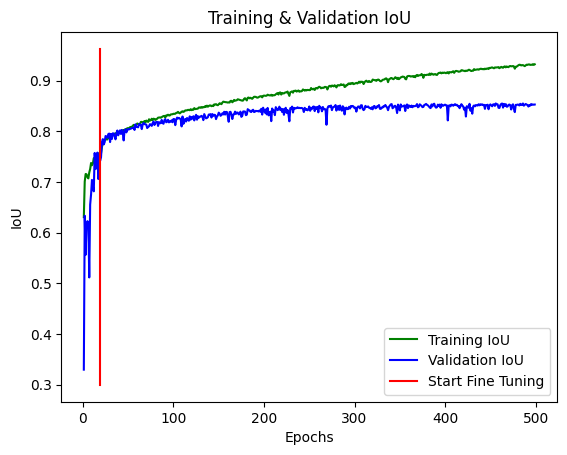

In [16]:
# Zusammenführen von Training- und Fine-Tuning-History
iou = model_history.history['binary_iou']
iou += history_fine.history['binary_iou']

val_iou = model_history.history['val_binary_iou']
val_iou += history_fine.history['val_binary_iou']


# laden des besten models
checkpoint_path = f'../output/{output_folder_prefix}_checkpoints/{model_name}'
unet = tf.keras.models.load_model(checkpoint_path, compile= False)
compile_model(unet, learning_rate)


# Evaluieren & Ergebnisse in Tabelle
eval_out = unet.evaluate(test_data_generator)

eval_out_path = '../output/final_runs.csv'
# Anlegen der Datei für ersten Durchlauf
if not os.path.isfile(FT_output_path):
    with open(eval_out_path, 'w', newline='') as f_object:
        writer_object = csv.writer(f_object, delimiter= ';')

        header = ['model_name', 'loss', 'accuracy', 'binary_iou', 'true_pos', 'false_pos', 'true_neg', 'false_neg', 'precision', 'recall', 'training_time [min]', 'max_val_iou', 'idx_max_val_iou' ]
        writer_object.writerow(header)

        row = []
    
        row.append(model_name)

        for x in eval_out:
            row.append(x)            

        writer_object.writerow(row)

# Anhängen an Datei für weitere Durchläufe
else:
    with open(FT_output_path, 'a', newline='') as f_object:
        row = []
        
        row.append(model_name)

        for x in eval_out:
            row.append(x)

        # Einfügen der Trainingszeit in Minuten
        row.append(training_time/60)

        # Einfügen der maximalen Val-IoU
        row.append(max(val_iou))

        # Einfügen des Index der maximalen Val-IoU
        row.append(np.argmax(val_iou))

        writer_object = csv.writer(f_object, delimiter= ';')

        writer_object.writerow(row)




"""
# Schreiben der Eval-Ergebnisse in csv
with open('../output/final_runs.csv', 'a') as f_object:
    row = []
    
    row.append(model_name)

    for x in eval_out:
        row.append(x)

    # Einfügen der Trainingszeit in Minuten
    row.append(training_time/60)

    # Einfügen der maximalen Val-IoU
    row.append(max(val_iou))

    # Einfügen des Index der maximalen Val-IoU
    row.append(np.argmax(val_iou))

    writer_object = csv.writer(f_object, delimiter= ';')

    writer_object.writerow(row)
"""

# Plotten
epochs = range(1, len(val_iou)+1)

plt.plot(epochs[0:(len(val_iou) - 1)], iou[0:(len(val_iou) - 1)], 'g', label= 'Training IoU')
plt.plot(epochs[0:(len(val_iou) - 1)], val_iou[0:(len(val_iou) - 1)], 'b', label= 'Validation IoU')

plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), 'r', label='Start Fine Tuning')

plt.title('Training & Validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()

plt.savefig(f'../output/plots/IoU/iou_{model_name}.png', bbox_inches='tight', dpi= 500)

plt.show()

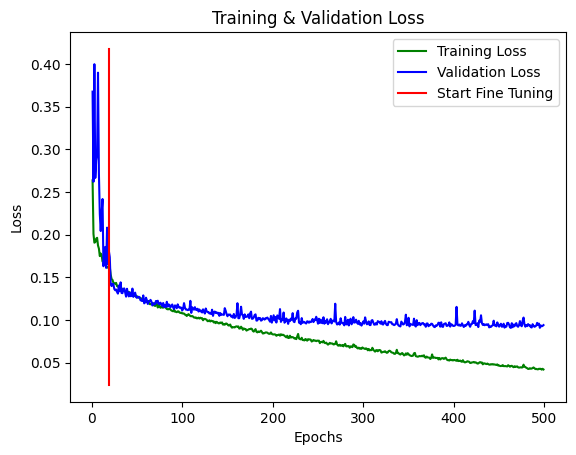

In [17]:
loss = model_history.history['loss']
loss += history_fine.history['loss']

val_loss = model_history.history['val_loss']
val_loss += history_fine.history['val_loss']

plt.plot(epochs[0:(len(val_iou) - 1)], loss[0:(len(val_iou) - 1)], 'g', label= 'Training Loss')
plt.plot(epochs[0:(len(val_iou) - 1)], val_loss[0:(len(val_iou) - 1)], 'b', label= 'Validation Loss')

plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), 'r', label='Start Fine Tuning')

plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig(f'../output/plots/Loss/loss_{model_name}.png', bbox_inches='tight', dpi= 500)

plt.show()

In [18]:
#checkpoint_path = f'../output/{output_folder_prefix}_checkpoints/{model_name}'

#unet = tf.keras.models.load_model(checkpoint_path, compile= False)
#compile_model(unet, learning_rate)

# Prognose mit Hilfe des geladenen besten Modells
prediction = unet.predict(test_data_generator)

# Erstellung einer binären Maske aus den wahrscheinlichkeiten, Schwellwert 0.5
out = (prediction > 0.5).astype(np.uint8)

# lediglich halbe Batch Size in eine Abbildung wegen Übersichtlichkeit
rows = int(batch_size / 2)
columns = 3

# Anzahl verfügbarer Batches des Data-Generators
no_of_batches = test_data_generator.__len__()

# Prognose kommt als Tensor mit der Länge der Anzahl der Beispiele
out_idx = 0

# Erstellen des Prognosen-Ordners
if not os.path.isdir(f'../output/predictions/{model_name}'):
    os.makedirs(f'../output/predictions/{model_name}')

# Input und Masken kommen als Batches, über die iteriert wird
for batch_no in range(0, no_of_batches):

    # iterieren über erste Hälfte des Batches
    fig, axs = plt.subplots(rows, columns, figsize=(5, 20))

    for i in range(rows):
        axs[i, 0].imshow(out[out_idx])
        axs[i, 0].set_title('Prediction')

        axs[i, 1].imshow(test_data_generator[batch_no][1][i])
        axs[i, 1].set_title('Truth')

        axs[i, 2].imshow(reverse_scaling(test_data_generator[batch_no][0][i])[:,:,:3])
        axs[i, 2].set_title('Input')

        out_idx += 1

    fig.tight_layout(w_pad=0.1, h_pad=0.1)

    plt.savefig(f'../output/predictions/{model_name}/prediction_{model_name}_{batch_no}_I.png', bbox_inches='tight')
    plt.close(fig)

    # iterieren über zweite Hälfte des Batches
    fig, axs = plt.subplots(rows, columns, figsize=(5, 20))

    for i in range(rows):
        axs[i, 0].imshow(out[out_idx])
        axs[i, 0].set_title('Prediction')

        axs[i, 1].imshow(test_data_generator[batch_no][1][rows + i])
        axs[i, 1].set_title('Truth')

        axs[i, 2].imshow(reverse_scaling(test_data_generator[batch_no][0][rows + i])[:,:,:3])
        axs[i, 2].set_title('Input')

        out_idx += 1

    fig.tight_layout(w_pad=0.1, h_pad=0.1)

    print(batch_no)
    plt.savefig(f'../output/predictions/{model_name}/prediction_{model_name}_{batch_no}_II.png', bbox_inches='tight', dpi= 400)
    plt.close(fig)

# Zusammenführen der .log-Dateien von Initial- und Fine-Tuning Training und Schreiben in neue CSV-Datei
combine_log_files(output_folder_prefix, model_name)

66/66 [==============================] - 9s 120ms/step
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65


In [35]:
import re
idx = 0

conv_idx_list = []

for i, layer in enumerate(reversed(unet.layers)):
    if layer.name == 'up_sampling2d':
        idx = 0
    #print(layer.name)
    if re.search(r"conv$", layer.name):
        conv_idx_list.append(idx)
        #print(idx, layer.name)

    idx +=1

conv_idx_list   



[4,
 7,
 11,
 15,
 18,
 22,
 26,
 27,
 30,
 34,
 38,
 42,
 46,
 50,
 53,
 57,
 61,
 64,
 68,
 72,
 75,
 79,
 83,
 86,
 90,
 94,
 95,
 98,
 102,
 106,
 110,
 114,
 118,
 121,
 125,
 129,
 132,
 136,
 140,
 141,
 144,
 148,
 152,
 156,
 160,
 164,
 167,
 171,
 175,
 176,
 179,
 183,
 188]

In [7]:
unet.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 224, 224, 4  0           []                               
                                )]                                                                
                                                                                                  
 split_input (Lambda)           [(None, 224, 224, 1  0           ['input[0][0]']                  
                                ),                                                                
                                 (None, 224, 224, 1                                               
                                ),                                                                
                                 (None, 224, 224, 1                                         

In [32]:
#model_name = "Final_AVG_rgbDrop_0_earlyStop_True_e500"

def combine_log_files():
    # Zusammenführen der .log Dateien von Initial- und Fine-Tuning Training und Schreiben in neue CSV-Datei
    filenames = [f'../output/{output_folder_prefix}_logger/{model_name}_I.log', f'../output/{output_folder_prefix}_logger/{model_name}.log']
    with open(f'../output/{output_folder_prefix}_logger/{model_name}.csv', 'w') as outfile:
        # spezifizieren des Delimiters für Excel in erster Zeile
        outfile.write('sep=,\n')

        for i, fname in enumerate(filenames):
            with open(fname) as infile:
                reader = csv.reader(infile)

                for j, row in enumerate(reader):
                    # überspringen des 2. Headers
                    if i == 1 and j == 0:
                        continue

                    delimiter = ','
                    list_to_string = delimiter.join(row)
                    list_to_string += '\n'

                    outfile.write(list_to_string)

In [14]:
with open(f'../output/{output_folder_prefix}_logger/{model_name}_I.log') as infile:
    reader = csv.reader(infile)
    for i, row in enumerate(reader):
        if i == 0:
            continue
        print(row)

['0', '0.7961242198944092', '0.6587730646133423', '20309084.0', '44833484.0', '0.24731293320655823', '0.7116237282752991', '0.8449028730392456', '143743008.0', '110635216.0', '0.8323593139648438', '0.7104504108428955', '6571040.0', '11194135.0', '0.19853559136390686', '0.7745783925056458', '0.8540922403335571', '49742008.0', '38464532.0']
['1', '0.8555810451507568', '0.7428621053695679', '19262012.0', '26882816.0', '0.17415392398834229', '0.8062108755111694', '0.8530752658843994', '161536704.0', '111839176.0', '0.8509215116500854', '0.7363330125808716', '7721061.0', '8077029.0', '0.17862582206726074', '0.8224303126335144', '0.8289172649383545', '52764112.0', '37409496.0']
['2', '0.868036687374115', '0.7619959115982056', '18203548.0', '23961460.0', '0.15954600274562836', '0.8248876929283142', '0.8611232042312622', '164482416.0', '112873368.0', '0.855846107006073', '0.7469853162765503', '3632307.0', '11643931.0', '0.15823477506637573', '0.7808046936988831', '0.9194782376289368', '4921813

In [158]:
unet.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 224, 224, 4  0           []                               
                                )]                                                                
                                                                                                  
 split_input (Lambda)           [(None, 224, 224, 1  0           ['input[0][0]']                  
                                ),                                                                
                                 (None, 224, 224, 1                                               
                                ),                                                                
                                 (None, 224, 224, 1                                         

In [12]:
unet.save(f'{model_name}.h5')